# DataKit Challenge – Producers Direct - 2025

This project uses anonymized data from Producers Direct, originating from the former WeFarm
SMS-based peer-to-peer farming platform. The dataset captures real-world conversations among
smallholder farmers across East Africa and Latin America, spanning multiple years and languages
(English, Swahili, Luganda, and Nyn).

The data includes millions of farmer-submitted questions and responses, farming tips and basic demographic and farming attributes. These conversations
reflect how farmers seek advice on crops, pests, weather, markets, and broader livelihood topics
under varying environmental and seasonal conditions.

The objective of this analysis is to extract meaningful patterns and actionable insights that
can support climate resilience, productivity, financial inclusion, and knowledge-sharing among
smallholder farmers. Insights generated through this work aim to inform Producers Direct’s
strategy for building data-driven, farmer-owned digital advisory services.



In [68]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import missingno as msno
from matplotlib.ticker import MaxNLocator
import networkx as nx
from wordcloud import WordCloud
from pandas_profiling import ProfileReport

In [2]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [3]:
os.makedirs("images", exist_ok=True)

In [4]:
# Load the cleaned and preprocessed dataset from a Parquet file for efficient storage and fast I/O
df = pd.read_parquet("/kaggle/input/cleaned-data-new/df_eng_clean_step1 (2).parquet")
# Display the first few rows to quickly inspect the data structure and verify successful loading
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

question_id  question_user_id  question_language  \
0      3849061            521327                  0   
1      3849084              6642                  0   
2      3849098            526375                  0   
3      3849100            237506                  0   
4      3849100            237506                  0   

                                    question_content question_topic  \
0  Q this goes to wefarm. is it possible to get f...           None   
1  Q-i have stock rabbit's urine for 5 weeks mash...         rabbit   
2  Q J Have Mi 10000 Can J Start Aproject Of Pout...        poultry   
3                   WHERE DO I GET SEEDS OF COCONUT?            pig   
4                   WHERE DO I GET SEEDS OF COCONUT?        coconut   

              question_sent  response_id  response_user_id response_language  \
0 2017-11-22 12:25:05+00:00      4334249            526113               eng   
1 2017-11-22 12:25:10+00:00      3852272             35690               eng   
2 2017-11-22 12:25:12+00:00      3859675            522795               eng   
3 2017-11-22 12:25:12+00:00      4263505            412335               eng   
4 2017-11-22 12:25:12+00:00      3852604            412335               eng   

                                    response_content  ... response_user_dob  \
0          Q1 which stage is marleks last vaccinated  ...              None   
1                                        Q165#Ksh120  ...              None   
2  Q5 10000 is not enough because the materials n...  ...              None   
3  Q11:try kisumu ,migori ,homa bay,siaya and any...  ...              None   
4                                  Q11:coast Cereals  ...              None   

   response_user_created_at year      q_date  q_month  q_year r_date r_month  \
0 2017-11-22 10:13:03+00:00  NaN  2017-11-22  2017-11  2017.0   None     NaT   
1 2015-11-14 19:59:19+00:00  NaN  2017-11-22  2017-11  2017.0   None     NaT   
2 2017-11-21 07:08:05+00:00  NaN  2017-11-22  2017-11  2017.0   None     NaT   
3 2017-10-03 17:35:12+00:00  NaN  2017-11-22  2017-11  2017.0   None     NaT   
4 2017-10-03 17:35:12+00:00  NaN  2017-11-22  2017-11  2017.0   None     NaT   

  r_year account_age_days  
0    NaN              2.0  
1    NaN            847.0  
2    NaN              0.0  
3    NaN            148.0  
4    NaN            148.0  

[5 rows x 32 columns]

In [5]:
# List all column names to understand the dataset structure and available features
df.columns

Index(['question_id', 'question_user_id', 'question_language',
       'question_content', 'question_topic', 'question_sent', 'response_id',
       'response_user_id', 'response_language', 'response_content',
       'response_topic', 'response_sent', 'question_user_type',
       'question_user_status', 'question_user_country_code',
       'question_user_gender', 'question_user_dob', 'question_user_created_at',
       'response_user_type', 'response_user_status',
       'response_user_country_code', 'response_user_gender',
       'response_user_dob', 'response_user_created_at', 'year', 'q_date',
       'q_month', 'q_year', 'r_date', 'r_month', 'r_year', 'account_age_days'],
      dtype='object')

In [6]:
# Generate descriptive statistics for numerical features to understand

print("\n=== Numeric Summary ===")
print(df.describe())


=== Numeric Summary ===
        question_id  question_user_id  question_language   response_id  \
count  1.152399e+07      1.152399e+07         11523993.0  1.152399e+07   
mean   2.720621e+07      1.558422e+06                0.0  2.739626e+07   
std    1.566402e+07      9.691332e+05                0.0  1.568635e+07   
min    3.849061e+06      7.000000e+00                0.0  3.849209e+06   
25%    1.409100e+07      8.680850e+05                0.0  1.425435e+07   
50%    2.356951e+07      1.334506e+06                0.0  2.379077e+07   
75%    4.041796e+07      2.214034e+06                0.0  4.062887e+07   
max    5.926151e+07      3.832740e+06                0.0  5.926219e+07   

       response_user_id          year         q_year        r_year  \
count      1.152399e+07  1.133027e+07  206347.000000  1.133027e+07   
mean       1.346732e+06  2.019001e+03    2017.622156  2.019001e+03   
std        9.230850e+05  1.003840e+00       0.484850  1.003840e+00   
min        7.000000e+00  2.0

In [7]:
# Convert relevant columns to datetime and verify types for reliable time-based analysis
date_cols = ['question_sent', 'response_sent',
             'question_user_created_at', 'response_user_created_at']

for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors='coerce')

df[date_cols].dtypes


question_sent               datetime64[ns, UTC]
response_sent               datetime64[ns, UTC]
question_user_created_at    datetime64[ns, UTC]
response_user_created_at    datetime64[ns, UTC]
dtype: object

In [8]:
# Identify the number of missing values in each column to assess data quality
df.isnull().sum()


question_id                          0
question_user_id                     0
question_language                    0
question_content                     0
question_topic                 1548673
question_sent                 11317646
response_id                          0
response_user_id                     0
response_language                    0
response_content                     0
response_topic                 7527577
response_sent                   193720
question_user_type                   0
question_user_status                 0
question_user_country_code           0
question_user_gender          11063776
question_user_dob             10669761
question_user_created_at       9382863
response_user_type                   0
response_user_status                 0
response_user_country_code           0
response_user_gender          10744844
response_user_dob             10325876
response_user_created_at       8469691
year                            193720
q_date                   

In [9]:
def ensure_datetime(df, cols):
    for c in cols:
        if c in df.columns and not np.issubdtype(df[c].dtype, np.datetime64):
            df[c] = pd.to_datetime(df[c], errors='coerce')

def age_at_event(dob_col, event_date_col):
    # returns integer age in years (handles NaT)
    dob = df[dob_col]
    event = df[event_date_col]
    # compute year difference then adjust if event before birthday in that year
    years = event.dt.year - dob.dt.year
    # where either is missing -> keep NaN
    adjust = ((event.dt.month < dob.dt.month) | 
              ((event.dt.month == dob.dt.month) & (event.dt.day < dob.dt.day)))
    years = years - adjust
    years = years.where(dob.notna() & event.notna(), other=np.nan)
    return years.astype('float')  # keep float so NaN handled nicely

def save_or_show(fig, name=None):
    # helper to either save or show - modify if you want to save charts:
    plt.show()

In [10]:
def ensure_datetime(df, cols):
    for c in cols:
        if c in df.columns:
            # If already datetime (tz-aware or naive), leave as is
            if not pd.api.types.is_datetime64_any_dtype(df[c]):
                df[c] = pd.to_datetime(df[c], errors='coerce')


In [11]:
# Convert all specified columns to datetime to ensure consistent time-based analysis
ensure_datetime(df, [
    'question_sent','response_sent',
    'q_date','r_date',
    'question_user_created_at','response_user_created_at',
    'question_user_dob','response_user_dob'
])


### Farmer Produce KPI's

In [12]:
# Count the total number of unique questioners and responders in the dataset
total_unique_questioners = df['question_user_id'].nunique()
total_unique_responders  = df['response_user_id'].nunique()

print("Total Unique Questioners:", total_unique_questioners)
print("Total Unique Responders:", total_unique_responders)


Total Unique Questioners: 495159
Total Unique Responders: 446904


In [13]:
# Calculate the average number of questions per questioner and responses per responder
avg_q_per_user = (
    df.groupby('question_user_id')
          .size()
          .mean()
)

avg_r_per_user = (
    df.groupby('response_user_id')
          .size()
          .mean()
)

print("Avg questions per questioner:", round(avg_q_per_user, 2))
print("Avg responses per responder:", round(avg_r_per_user, 2))


Avg questions per questioner: 23.27
Avg responses per responder: 25.79


In [14]:
# Aggregate unique questioners and responders by country and calculate their percentage share
country_q = (
    df.groupby('question_user_country_code')['question_user_id']
          .nunique()
          .reset_index(name='unique_questioners')
)

country_r = (
    df.groupby('response_user_country_code')['response_user_id']
          .nunique()
          .reset_index(name='unique_responders')
)

country_kpi = country_q.merge(
    country_r,
    left_on='question_user_country_code',
    right_on='response_user_country_code',
    how='outer'
).fillna(0)

country_kpi['q_percent'] = (
    country_kpi['unique_questioners'] /
    country_kpi['unique_questioners'].sum() * 100
)

country_kpi['r_percent'] = (
    country_kpi['unique_responders'] /
    country_kpi['unique_responders'].sum() * 100
)

country_kpi


question_user_country_code  unique_questioners response_user_country_code  \
0                         GB                41.0                          0   
1                         KE            282472.0                          0   
2                         TZ                 1.0                          0   
3                         UG            212645.0                          0   
4                          0                 0.0                         gb   
5                          0                 0.0                         ke   
6                          0                 0.0                         tz   
7                          0                 0.0                         ug   

   unique_responders  q_percent  r_percent  
0                0.0   0.008280   0.000000  
1                0.0  57.046726   0.000000  
2                0.0   0.000202   0.000000  
3                0.0  42.944791   0.000000  
4               48.0   0.000000   0.010741  
5           256097.0   0.000000  57.304701  
6                1.0   0.000000   0.000224  
7           190758.0   0.000000  42.684335

In [15]:
# Count unique questioners and responders by gender to understand gender distribution
gender_q = (
    df[['question_user_id','question_user_gender']]
    .dropna()
    .drop_duplicates()
    ['question_user_gender']
    .value_counts()
)

gender_r = (
    df[['response_user_id','response_user_gender']]
    .dropna()
    .drop_duplicates()
    ['response_user_gender']
    .value_counts()
)

print("Questioners gender:")
print(gender_q)

print("\nResponders gender:")
print(gender_r)


Questioners gender:
question_user_gender
male      10497
female     2496
Name: count, dtype: int64

Responders gender:
response_user_gender
male      15050
female     3486
Name: count, dtype: int64


In [16]:
# Extract birth year from user DOB for questioners and responders to enable age-related analysis
df['q_birth_year'] = pd.to_datetime(
    df['question_user_dob'], errors='coerce'
).dt.year

df['r_birth_year'] = pd.to_datetime(
    df['response_user_dob'], errors='coerce'
).dt.year


In [17]:
# Compute the distribution of birth years for unique questioners and responders
q_birth_density = (
    df[['question_user_id','q_birth_year']]
    .dropna()
    .drop_duplicates()
    ['q_birth_year']
    .value_counts()
    .sort_index()
)

r_birth_density = (
    df[['response_user_id','r_birth_year']]
    .dropna()
    .drop_duplicates()
    ['r_birth_year']
    .value_counts()
    .sort_index()
)


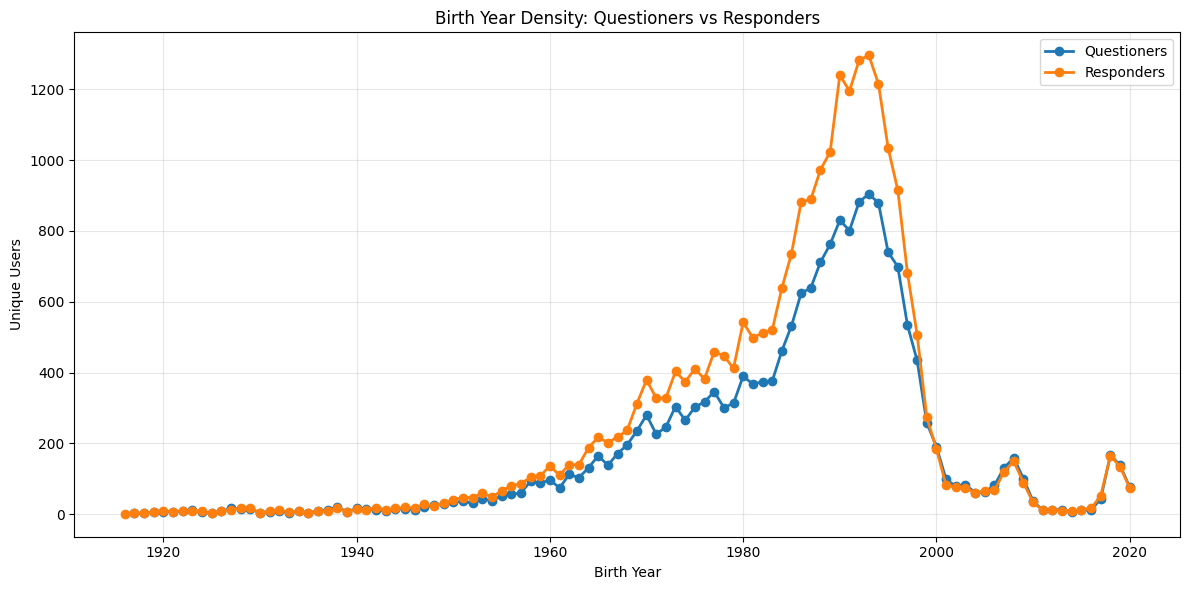

In [18]:
# Plot and compare the distribution of birth years for questioners and responders
plt.figure(figsize=(12,6))

plt.plot(
    q_birth_density.index,
    q_birth_density.values,
    marker='o',
    linewidth=2,
    label='Questioners'
)

plt.plot(
    r_birth_density.index,
    r_birth_density.values,
    marker='o',
    linewidth=2,
    label='Responders'
)

plt.xlabel('Birth Year')
plt.ylabel('Unique Users')
plt.title('Birth Year Density: Questioners vs Responders')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()

# Save the plot as a PNG file and display it
plt.savefig(
    "images/Birth Year Density: Questioners vs Responders .png",
    dpi=150,
    bbox_inches="tight"
)
plt.show()


In [19]:
# Calculate account age in days at the time of each question/response for questioners and responders
df['question_user_created_at'] = pd.to_datetime(
    df['question_user_created_at'], errors='coerce'
)
df['response_user_created_at'] = pd.to_datetime(
    df['response_user_created_at'], errors='coerce'
)

df['Q_account_age'] = (
    df['question_sent'] - df['question_user_created_at']
).dt.days

df['R_account_age'] = (
    df['response_sent'] - df['response_user_created_at']
).dt.days


In [20]:
# Compute the distribution of account ages (in days) for unique questioners and responders
# Questioners
q_account_density = (
    df[['question_user_id','Q_account_age']]
    .dropna()
    .drop_duplicates()
    .groupby('Q_account_age')
    .size()
)

# Responders
r_account_density = (
    df[['response_user_id','R_account_age']]
    .dropna()
    .drop_duplicates()
    .groupby('R_account_age')
    .size()
)

df


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

question_id  question_user_id  question_language  \
0             3849061            521327                  0   
1             3849084              6642                  0   
2             3849098            526375                  0   
3             3849100            237506                  0   
4             3849100            237506                  0   
...               ...               ...                ...   
11523988     59256225           1904306                  0   
11523989     59259045           2772369                  0   
11523990     59260982            110220                  0   
11523991     59260982            110220                  0   
11523992     59261512           3735072                  0   

                                           question_content question_topic  \
0         Q this goes to wefarm. is it possible to get f...           None   
1         Q-i have stock rabbit's urine for 5 weeks mash...         rabbit   
2         Q J Have Mi 10000 Can J Start Aproject Of Pout...        poultry   
3                          WHERE DO I GET SEEDS OF COCONUT?            pig   
4                          WHERE DO I GET SEEDS OF COCONUT?        coconut   
...                                                     ...            ...   
11523988  Q which crop should we plant in this very litt...          plant   
11523989  I want to grow cabbage someone to give me the ...        cabbage   
11523990  Q how can i permanently control birds destroyi...          maize   
11523991  Q how can i permanently control birds destroyi...           bird   
11523992     Q. Which is the best Season of dlanting tomato         tomato   

                     question_sent  response_id  response_user_id  \
0        2017-11-22 12:25:05+00:00      4334249            526113   
1        2017-11-22 12:25:10+00:00      3852272             35690   
2        2017-11-22 12:25:12+00:00      3859675            522795   
3        2017-11-22 12:25:12+00:00      4263505            412335   
4        2017-11-22 12:25:12+00:00      3852604            412335   
...                            ...          ...               ...   
11523988                       NaT     59256229           3372507   
11523989                       NaT     59259053           3681140   
11523990                       NaT     59261028           1493318   
11523991                       NaT     59261028           1493318   
11523992                       NaT     59261534           1493318   

         response_language                                   response_content  \
0                      eng          Q1 which stage is marleks last vaccinated   
1                      eng                                        Q165#Ksh120   
2                      eng  Q5 10000 is not enough because the materials n...   
3                      eng  Q11:try kisumu ,migori ,homa bay,siaya and any...   
4                      eng                                  Q11:coast Cereals   
...                    ...                                                ...   
11523988               eng  Q chick availabe at 60 bob only cal/whatsaap m...   
11523989               eng                                                  1   
11523990               eng                 Open the forum as soon as possible   
11523991               eng                 Open the forum as soon as possible   
11523992               eng  Bw. We farm, tell us where to head. Are you in...   

          ...  q_month  q_year     r_date  r_month  r_year account_age_days  \
0         ...  2017-11  2017.0        NaT      NaT     NaN              2.0   
1         ...  2017-11  2017.0        NaT      NaT     NaN            847.0   
2         ...  2017-11  2017.0        NaT      NaT     NaN              0.0   
3         ...  2017-11  2017.0        NaT      NaT     NaN            148.0   
4         ...  2017-11  2017.0        NaT      NaT     NaN            148.0   
...       ...      ...     ...        ...      ...  

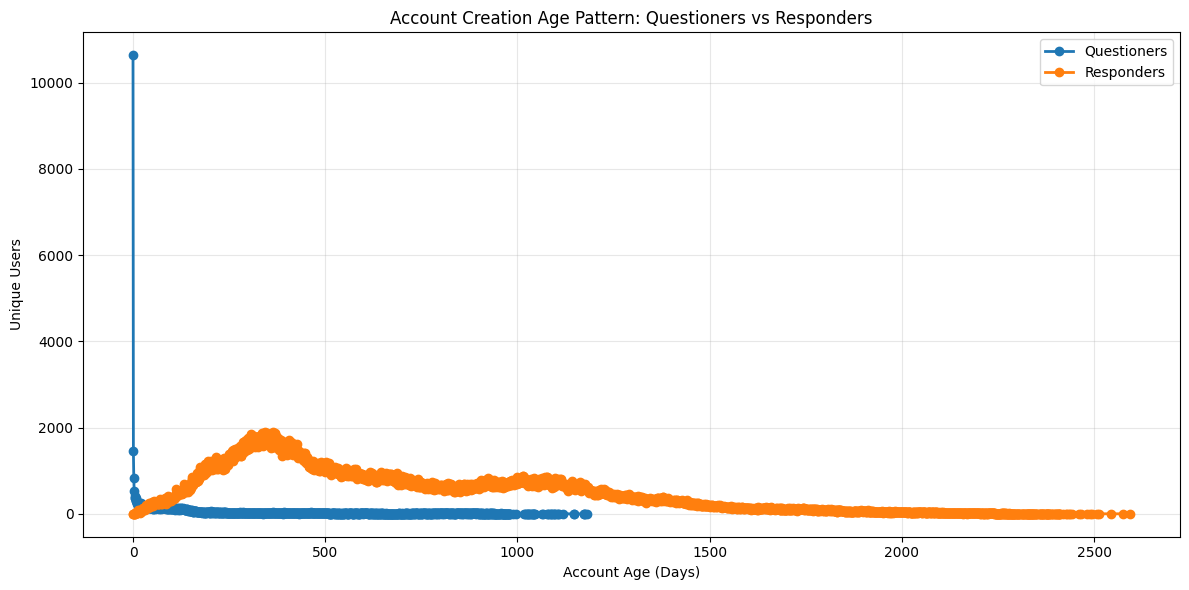

In [21]:
# Plot the distribution of account ages for questioners and responders to visualize activity patterns
plt.figure(figsize=(12,6))

plt.plot(
    q_account_density.index,
    q_account_density.values,
    marker='o',
    linewidth=2,
    label='Questioners'
)

plt.plot(
    r_account_density.index,
    r_account_density.values,
    marker='o',
    linewidth=2,
    label='Responders'
)

plt.xlabel('Account Age (Days)')
plt.ylabel('Unique Users')
plt.title('Account Creation Age Pattern: Questioners vs Responders')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(
    "Account Creation Age Pattern: Questioners vs Responders.png",
    dpi=150,
    bbox_inches="tight"
)
plt.show()


In [22]:
# Calculate the percentage of questions that received at least one response
answer_coverage_rate = (
    df['response_user_id'].notna().mean() * 100
)

answer_coverage_rate


100.0

In [23]:
# Calculate the percentage of total responses contributed by the top 10% of responders to assess expert concentration
top_10_responders = (
    df['response_user_id']
    .value_counts()
    .head(int(0.1 * df['response_user_id'].nunique()))
    .sum()
)

expert_concentration = top_10_responders / len(df) * 100
expert_concentration


67.0474027535421

In [24]:
# Compute the percentage of questions that have at least one response
answer_coverage_rate = (
    df['response_user_id'].notna().mean() * 100
)

answer_coverage_rate


100.0

In [25]:
# Calculate the proportion of total responses contributed by the top 10% of responders to measure expert concentration
top_10_responders = (
    df['response_user_id']
    .value_counts()
    .head(int(0.1 * df['response_user_id'].nunique()))
    .sum()
)

expert_concentration = top_10_responders / len(df) * 100
expert_concentration


67.0474027535421

In [26]:
# Calculate the percentage of responses coming from users in a different country than the questioner
cross_country_rate = (
    (df['question_user_country_code'] !=
     df['response_user_country_code'])
    .mean() * 100
)

cross_country_rate


100.0

In [27]:
# Compute the engagement ratio: number of unique responders per unique questioner
engagement_ratio = total_unique_responders / total_unique_questioners
engagement_ratio


0.9025464547751328

# EDA Analysis

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


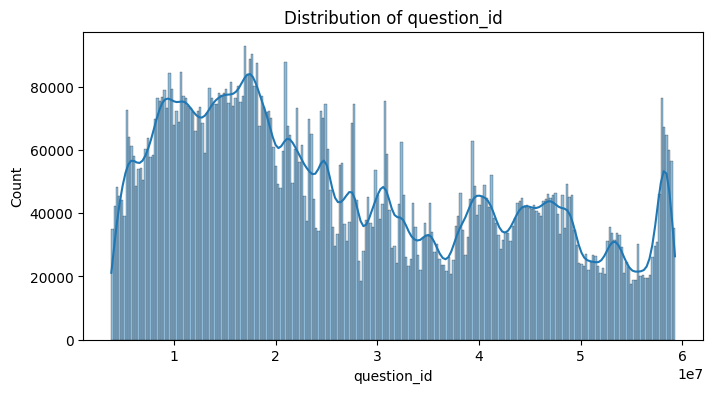

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


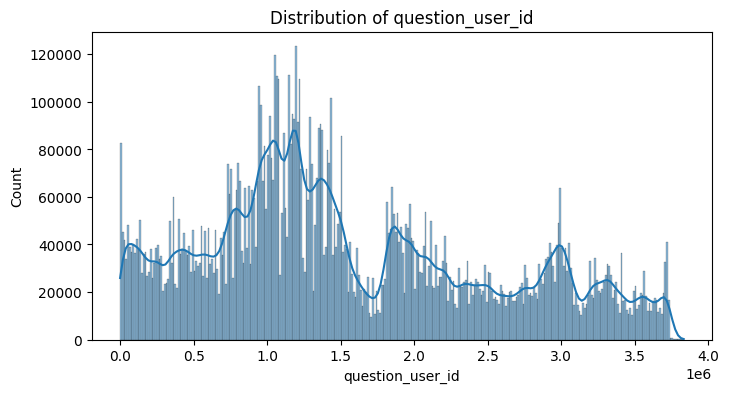

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


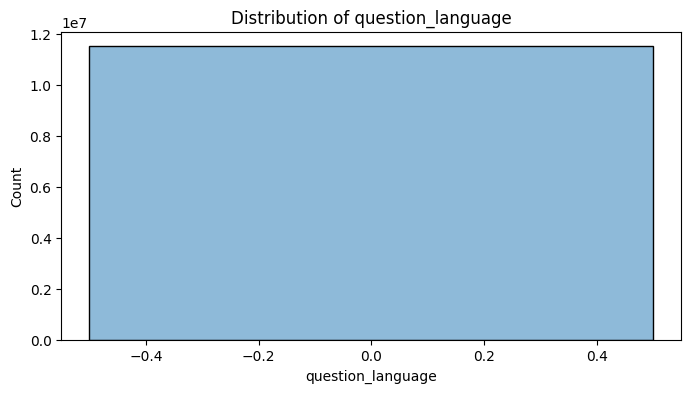

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


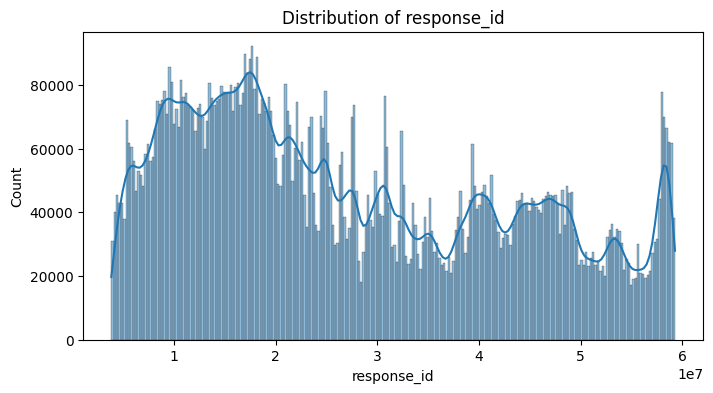

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


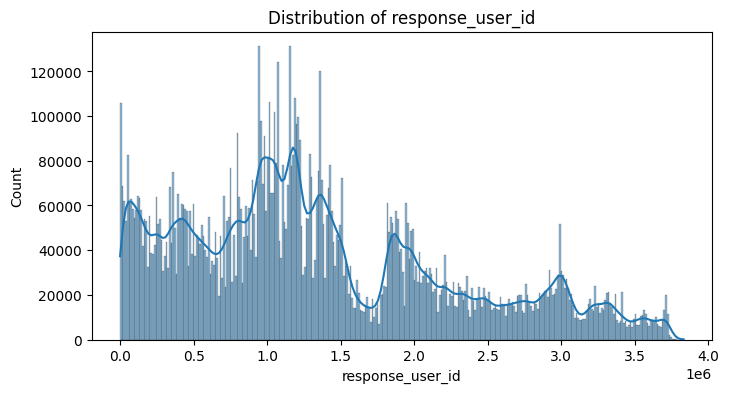

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


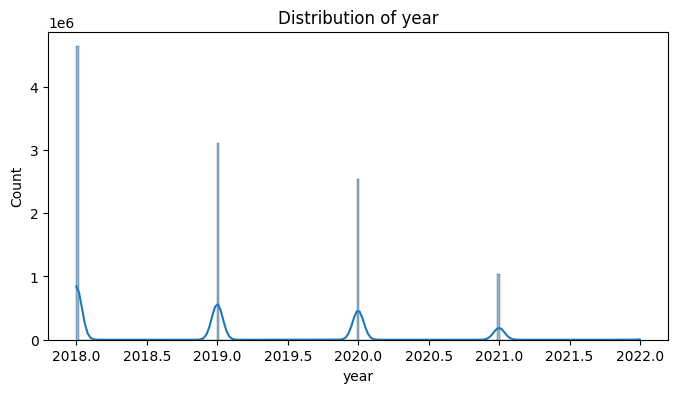

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


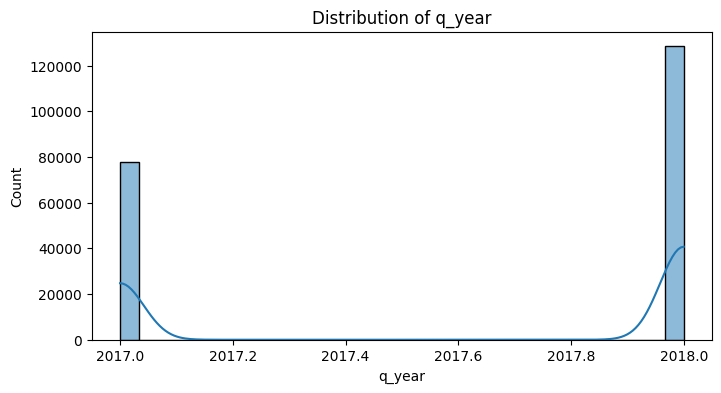

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


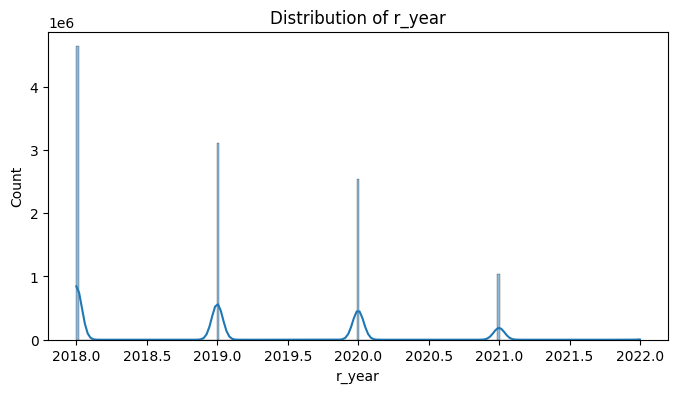

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


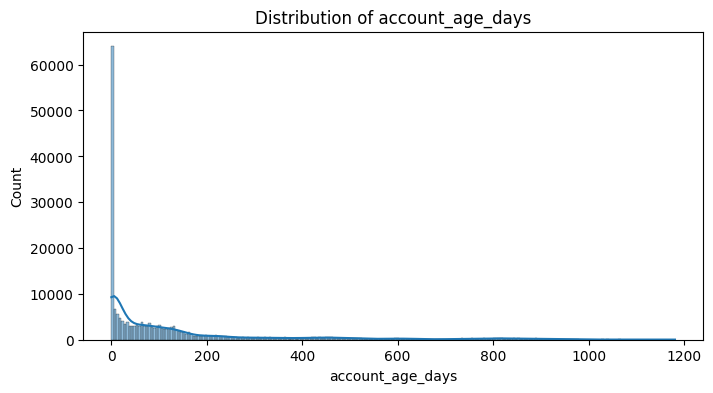

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


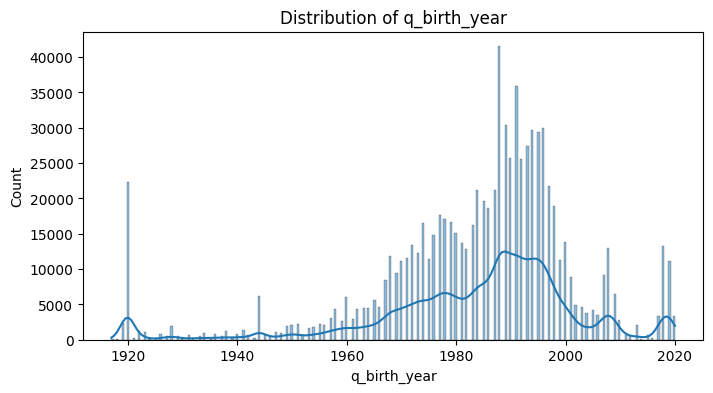

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


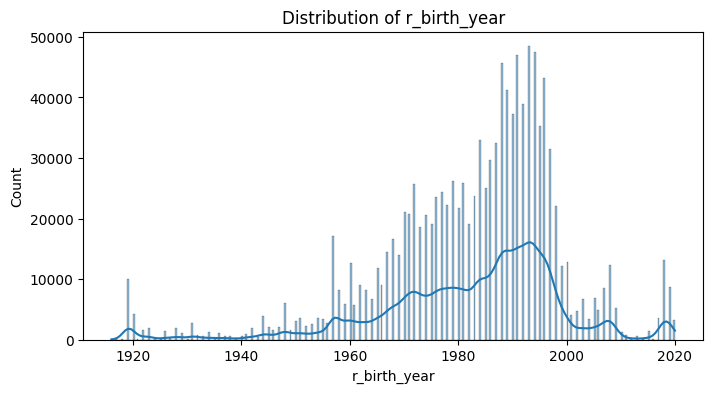

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


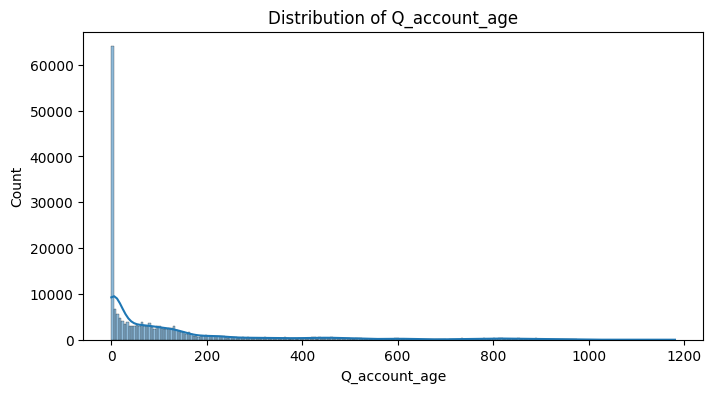

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


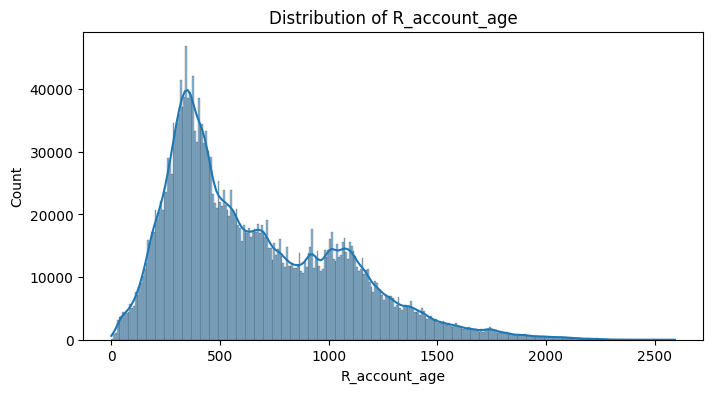

In [28]:
# Plot histograms with KDE for all numerical columns to visualize their distributions
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


## 1) Country level percentage

In [29]:
# Calculate the count and percentage of questions by user country
country_counts = df['question_user_country_code'].value_counts(dropna=False)
country_pct = 100 * country_counts / country_counts.sum()

Top countries by question volume (count, %):
                              count      count
question_user_country_code                    
KE                          7120776  61.790874
UG                          4402935  38.206679
GB                              272   0.002360
TZ                               10   0.000087


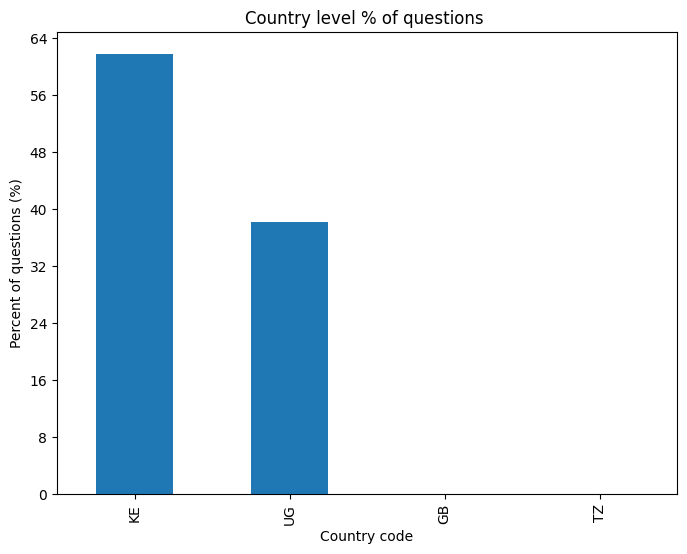

In [30]:
# Print top 10 countries and percentages
print("Top countries by question volume (count, %):")
print(pd.concat([country_counts.head(10), country_pct.head(10)], axis=1).rename(columns={0:'count',1:'percent'}))

plt.figure(figsize=(8,6))
country_pct.head(10).plot(kind='bar')
plt.xlabel('Country code')
plt.ylabel('Percent of questions (%)')
plt.title('Country level % of questions ')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
save_or_show(plt)

## 2) Country-wise question topic and response topic (clustered bar)

In [31]:
# Compute counts of questions and responses by country and topic to analyze topic distribution across regions
q_topic_by_country = df.groupby(['question_user_country_code','question_topic'])['question_id'].count().unstack(fill_value=0)
r_topic_by_country = df.groupby(['response_user_country_code','response_topic'])['response_id'].count().unstack(fill_value=0)


In [32]:
# Define top N countries and top M topics to focus visualizations on the most active regions and topics
TOP_COUNTRIES = 4
TOP_TOPICS = 10

In [33]:
top_countries = country_counts.head(TOP_COUNTRIES).index.tolist()
# sum across topics to pick most frequent topics overall
top_q_topics = q_topic_by_country.sum().sort_values(ascending=False).head(TOP_TOPICS).index.tolist()
top_r_topics = r_topic_by_country.sum().sort_values(ascending=False).head(TOP_TOPICS).index.tolist()

In [34]:
# Plot clustered bar for questions (country vs top topics)
q_plot_df = q_topic_by_country.loc[top_countries, top_q_topics].fillna(0)

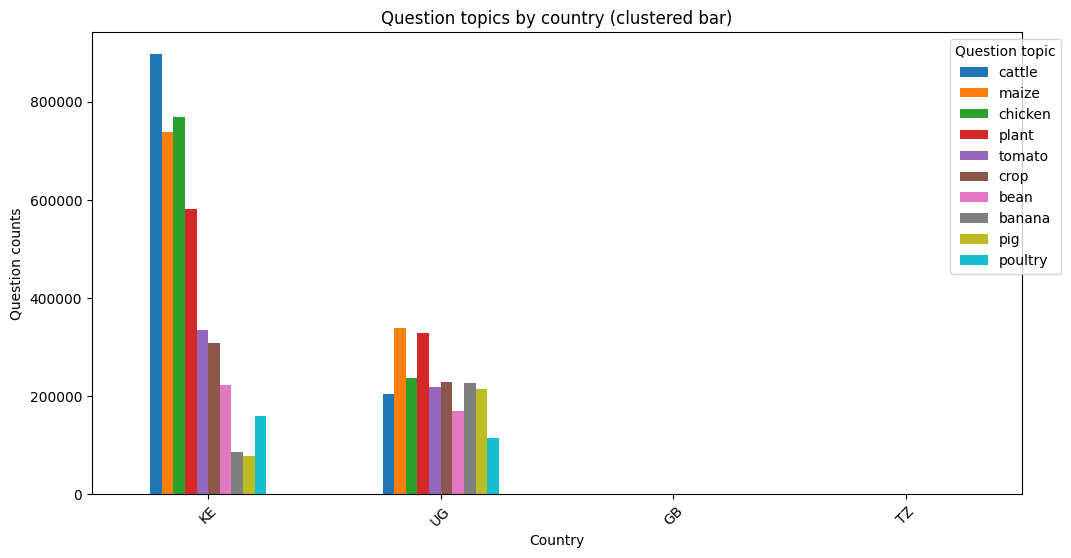

In [35]:
# Visualize question topic distribution by country using a clustered bar chart
ax = q_plot_df.plot(kind='bar', figsize=(12,6))
plt.xlabel('Country')
plt.ylabel('Question counts')
plt.title('Question topics by country (clustered bar)')
plt.xticks(rotation=45)
plt.legend(title='Question topic', bbox_to_anchor=(1.05,1))
save_or_show(plt)


In [36]:
# Normalize country codes and prepare response topic data for selected top countries and topics
top_countries = [c.lower() for c in top_countries]

r_plot_df = r_topic_by_country.loc[top_countries, top_r_topics].fillna(0)
r_plot_df


response_topic               plant  chicken  cattle   maize    crop  animal  \
response_user_country_code                                                    
ke                          285621   270111  270026  197916  147770   91041   
ug                          208761    85728   71721  110554  134867   96780   
gb                              30       15       2       4       2       3   
tz                               1        0       0       0       1       0   

response_topic                bean  tomato  banana  potato  
response_user_country_code                                  
ke                          100090   70080   33108   64957  
ug                           66465   48192   73144   22020  
gb                              13      17       2       4  
tz                               0       0       0       0

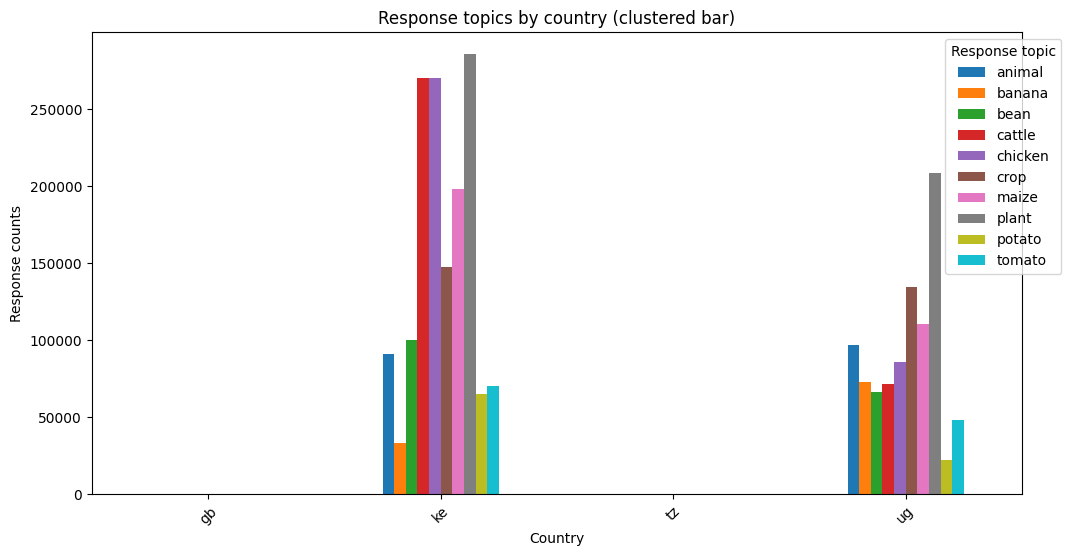

In [37]:
# Visualize response topic distribution by country using a clustered bar chart
# Normalize country codes to lowercase
top_countries = [c.lower() for c in top_countries]

# Safely select only available rows & columns
valid_countries = r_topic_by_country.index.intersection(top_countries)
valid_topics = r_topic_by_country.columns.intersection(top_r_topics)

# Plot clustered bar for responses
r_plot_df = r_topic_by_country.loc[valid_countries, valid_topics].fillna(0)

ax = r_plot_df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Country')
plt.ylabel('Response counts')
plt.title('Response topics by country (clustered bar)')
plt.xticks(rotation=45)
plt.legend(title='Response topic', bbox_to_anchor=(1.05, 1))

save_or_show(plt)


## 3) Question volume count (from date to date) - line chart


/tmp/ipykernel_47/3100250594.py:2: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  questions_by_day = df.set_index('q_month').resample('M')['question_id'].count()


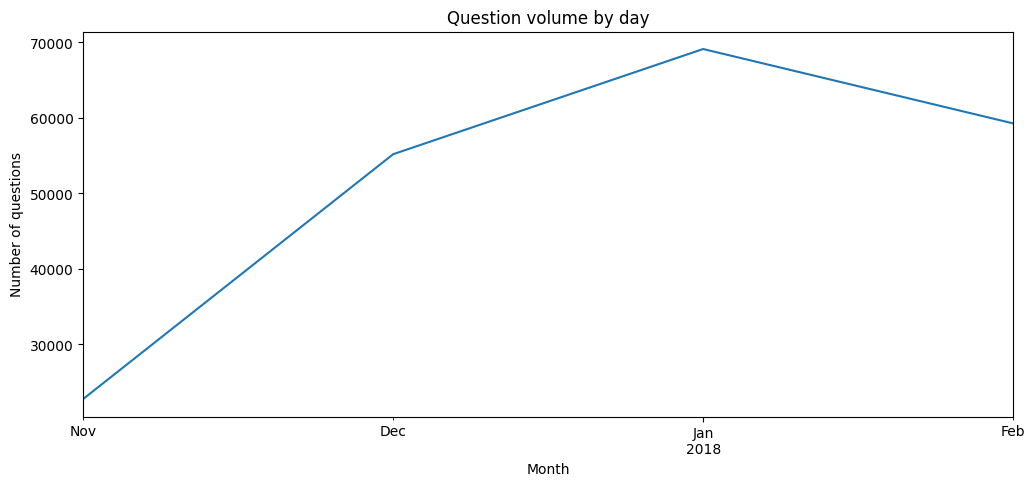

In [38]:
# Aggregate and plot the monthly trend of question volume over time
questions_by_day = df.set_index('q_month').resample('M')['question_id'].count()

plt.figure(figsize=(12,5))
questions_by_day.plot()
plt.xlabel('Month')
plt.ylabel('Number of questions')
plt.title('Question volume by day')
save_or_show(plt)


## 4) Response volume count (from date to date) 


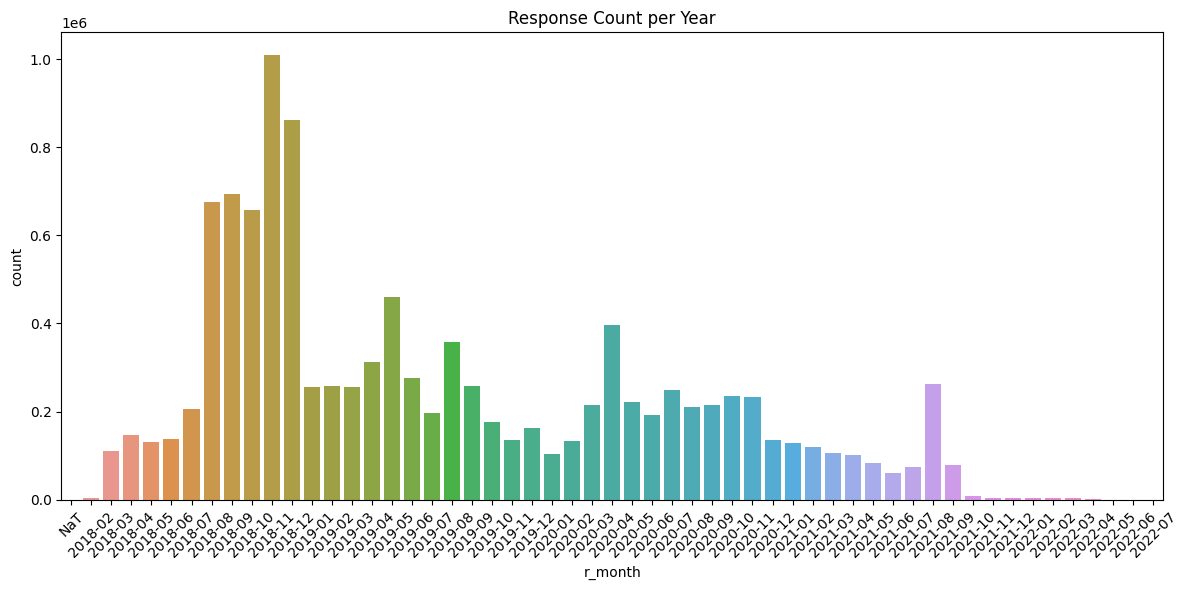

In [39]:
# Visualize the distribution of responses over time by month
plt.figure(figsize=(12, 6))

sns.countplot(data=df, x='r_month', order=sorted(df['r_month'].unique()))
plt.title("Response Count per Year")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5) DOB present vs null (% using pie chart) - for both Q and R

In [40]:
# Calculate and report the percentage of missing date-of-birth values for questioners and responders
q_dob_null = df['question_user_dob'].isna().mean()
r_dob_null = df['response_user_dob'].isna().mean()

print(f"Questioner DOB missing: {q_dob_null:.2%}, Responser DOB missing: {r_dob_null:.2%}")

Questioner DOB missing: 92.59%, Responser DOB missing: 89.60%


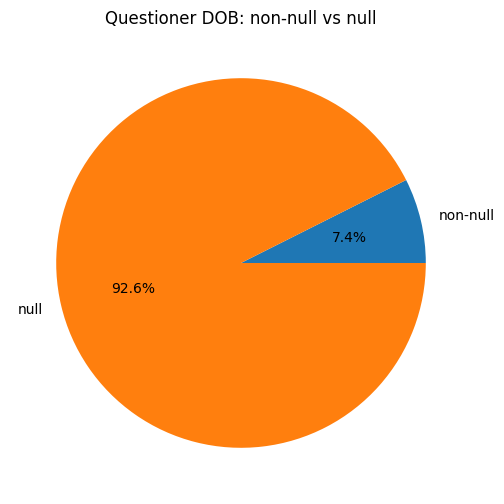

In [41]:
# Pie for questioner DOB availability
plt.figure(figsize=(6,6))
pd.Series([df['question_user_dob'].notna().sum(), df['question_user_dob'].isna().sum()],
          index=['non-null','null']).plot(kind='pie', autopct='%1.1f%%', ylabel='')
plt.title('Questioner DOB: non-null vs null')
save_or_show(plt)

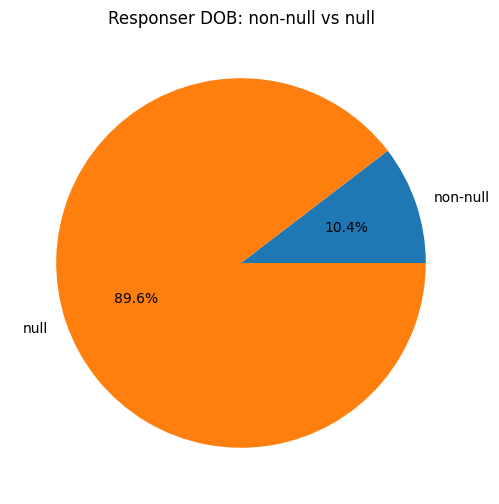

In [42]:
# Visualize the proportion of available vs missing responder date-of-birth values
plt.figure(figsize=(6,6))
pd.Series(
    [df['response_user_dob'].notna().sum(), df['response_user_dob'].isna().sum()],
    index=['non-null','null']
).plot(kind='pie', autopct='%1.1f%%', ylabel='')
plt.title('Responser DOB: non-null vs null')
save_or_show(plt)


## 5b) (You had two 5s) Create Age columns for questioner and responder

In [43]:
# Age at time of question for questioner, age at time of response for responder.
df['Age_questioner'] = age_at_event('question_user_dob','q_date')
df['Age_responser'] = age_at_event('response_user_dob','r_date')

In [44]:
# Quick stats
print("Age_questioner: count, mean, median, std")
print(df['Age_questioner'].describe())
print("Age_responser: count, mean, median, std")
print(df['Age_responser'].describe())

Age_questioner: count, mean, median, std
count    35595.000000
mean        31.638601
std         12.267803
min         -3.000000
25%         23.000000
50%         29.000000
75%         38.000000
max         99.000000
Name: Age_questioner, dtype: float64
Age_responser: count, mean, median, std
count    1.148334e+06
mean     3.576224e+01
std      1.732039e+01
min     -3.000000e+00
25%      2.500000e+01
50%      3.200000e+01
75%      4.500000e+01
max      1.040000e+02
Name: Age_responser, dtype: float64


## 5c) Age density patterns (questioner and responder on same chart)

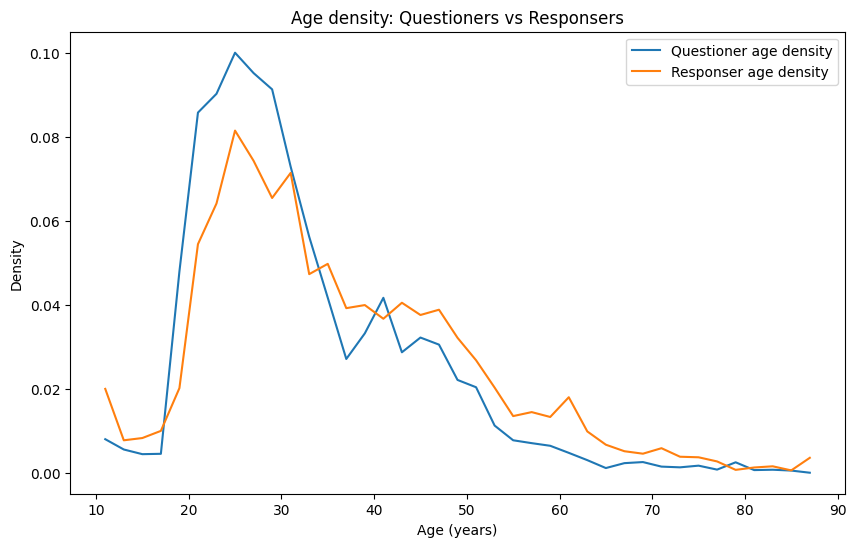

In [45]:
# Plot normalized age density distributions to compare questioners and responders
plt.figure(figsize=(10,6))

# Define age bins and compute histogram counts
bins = np.arange(10, 90, 2)
q_counts, _ = np.histogram(df['Age_questioner'].dropna(), bins=bins)
r_counts, _ = np.histogram(df['Age_responser'].dropna(), bins=bins)

# Normalize counts to densities for comparability
q_density = q_counts / q_counts.sum()
r_density = r_counts / r_counts.sum()

bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, q_density, label='Questioner age density')
plt.plot(bin_centers, r_density, label='Responser age density')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Age density: Questioners vs Responsers')
plt.legend()
save_or_show(plt)


## 6) Unique users age wise count (Q & R)


In [46]:
# Bucket questioner and responder ages into predefined age groups for cohort analysis
age_bins = [0,18,25,35,45,55,65,100]

df['Age_q_bucket'] = pd.cut(df['Age_questioner'], bins=age_bins)
df['Age_r_bucket'] = pd.cut(df['Age_responser'], bins=age_bins)


In [47]:
# Count unique questioners and responders in each age bucket to analyze age-based participation
unique_q_by_age = (
    df.groupby('Age_q_bucket')['question_user_id']
      .nunique(dropna=True)
)

unique_r_by_age = (
    df.groupby('Age_r_bucket')['response_user_id']
      .nunique(dropna=True)
)


/tmp/ipykernel_47/3941261346.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Age_q_bucket')['question_user_id']
/tmp/ipykernel_47/3941261346.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Age_r_bucket')['response_user_id']


In [48]:
# Combine unique questioner and responder counts by age bucket into a single DataFrame for comparison
unique_both = pd.concat([unique_q_by_age, unique_r_by_age], axis=1)
unique_both.columns = ['unique_q_users', 'unique_r_users']
print(unique_both)


           unique_q_users  unique_r_users
(0, 18]               146            1259
(18, 25]             1210            5971
(25, 35]             1530            9325
(35, 45]              760            4615
(45, 55]              420            2733
(55, 65]              139            1043
(65, 100]              76             551


In [49]:
# Compute the number of unique questioners for each exact age and sum to get total unique questioners
age_wise = df.groupby('Age_questioner')['question_user_id'].nunique()
age_wise.sum()


4441

<Figure size 800x500 with 0 Axes>

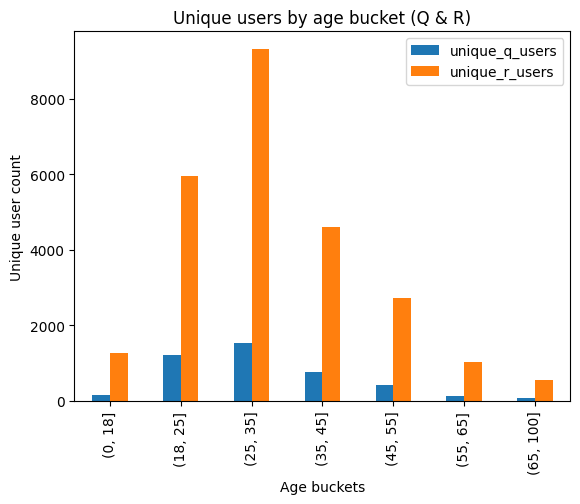

In [50]:
# Visualize the number of unique questioners and responders across age buckets
plt.figure(figsize=(8,5))
unique_both.plot(kind='bar')
plt.xlabel('Age buckets')
plt.ylabel('Unique user count')
plt.title('Unique users by age bucket (Q & R)')
save_or_show(plt)


In [51]:
# Add an 'Unknown' category to age buckets and fill missing ages with it for completeness
df['Age_q_bucket'] = df['Age_q_bucket'].cat.add_categories(['Unknown'])
df['Age_q_bucket'] = df['Age_q_bucket'].fillna('Unknown')

df['Age_r_bucket'] = df['Age_r_bucket'].cat.add_categories(['Unknown'])
df['Age_r_bucket'] = df['Age_r_bucket'].fillna('Unknown')


## 7) Account age columns creation

In [52]:
# We'll compute account age days as difference between event date and account created at
df['Q_account_Age_days'] = (df['question_sent'] - df['question_user_created_at']).dt.days
df['R_account_Age_days'] = (df['response_sent'] - df['response_user_created_at']).dt.days

In [53]:
# If there are negative values (created after event) set to NaN or 0 as appropriate
df.loc[df['Q_account_Age_days'] < 0, 'Q_account_Age_days'] = np.nan
df.loc[df['R_account_Age_days'] < 0, 'R_account_Age_days'] = np.nan


In [54]:
print("Q_account_Age_days stats:")
print(df['Q_account_Age_days'].describe())
print("R_account_Age_days stats:")
print(df['R_account_Age_days'].describe())


Q_account_Age_days stats:
count    206347.000000
mean        136.941909
std         209.202454
min           0.000000
25%           1.000000
50%          54.000000
75%         154.000000
max        1181.000000
Name: Q_account_Age_days, dtype: float64
R_account_Age_days stats:
count    2.860594e+06
mean     6.594424e+02
std      3.965766e+02
min      0.000000e+00
25%      3.480000e+02
50%      5.510000e+02
75%      9.370000e+02
max      2.594000e+03
Name: R_account_Age_days, dtype: float64


## 8) Line charts: Age of questioner vs Q_account_Age and Age of responder vs R_account_Age

In [55]:
# We'll do scatter+rolling mean or binned mean to show relationships rather than plotting 15M points.
def plot_age_vs_account_age(age_col, acc_age_col, title):
    # bin by age_col and compute mean account age
    tmp = df[[age_col, acc_age_col]].dropna()
    tmp['age_bin'] = pd.cut(tmp[age_col], bins=np.arange(10, 90, 5))
    mean_by_bin = tmp.groupby('age_bin')[acc_age_col].mean()
    bin_centers = [interval.mid for interval in mean_by_bin.index]
    plt.figure(figsize=(10,5))
    plt.plot(bin_centers, mean_by_bin)
    plt.xlabel(age_col)
    plt.ylabel(acc_age_col + ' (days)')
    plt.title(title)
    save_or_show(plt)

/tmp/ipykernel_47/3621397518.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_bin = tmp.groupby('age_bin')[acc_age_col].mean()


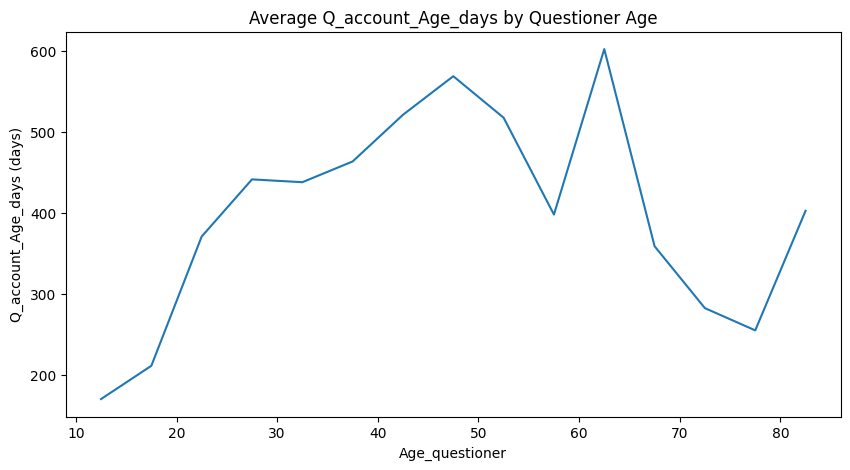

/tmp/ipykernel_47/3621397518.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_bin = tmp.groupby('age_bin')[acc_age_col].mean()


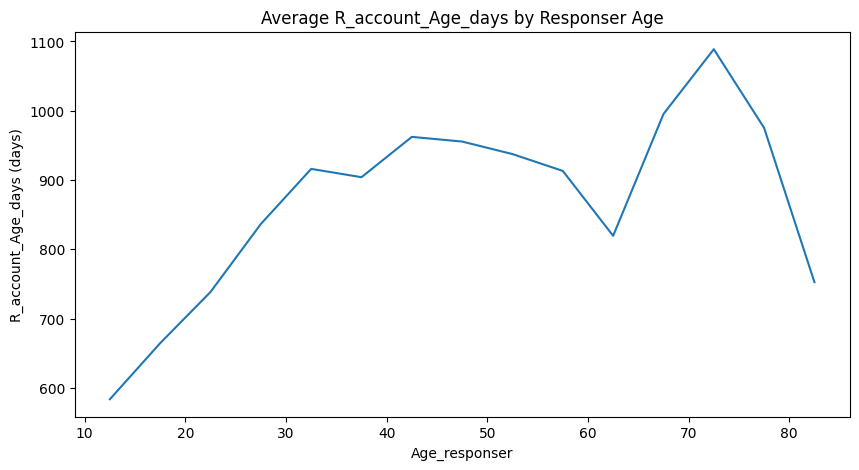

In [56]:
# Plot average account age by user age for questioners and responders to explore age vs experience patterns
plot_age_vs_account_age('Age_questioner','Q_account_Age_days','Average Q_account_Age_days by Questioner Age')
plot_age_vs_account_age('Age_responser','R_account_Age_days','Average R_account_Age_days by Responser Age')


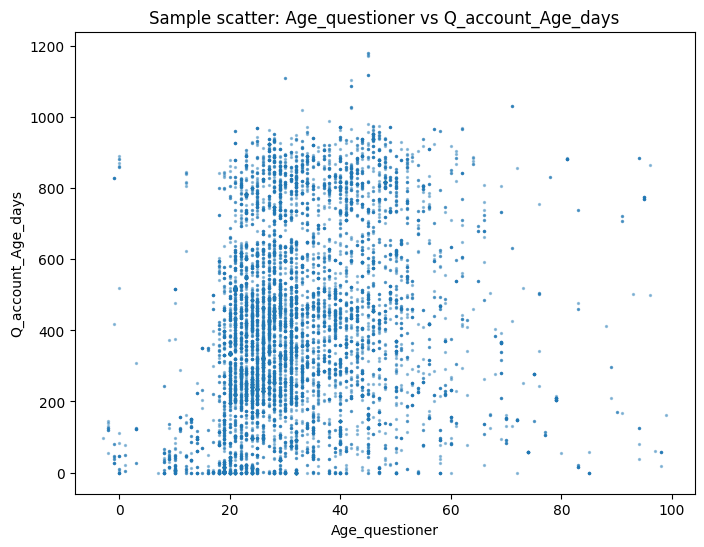

In [57]:
# Plot a sampled scatter of questioner age vs account age to visualize individual-level patterns without overplotting
sample = df[['Age_questioner','Q_account_Age_days']].dropna().sample(min(20000, int(df.shape[0]*0.001)))
plt.figure(figsize=(8,6))
plt.scatter(sample['Age_questioner'], sample['Q_account_Age_days'], s=2, alpha=0.4)
plt.xlabel('Age_questioner')
plt.ylabel('Q_account_Age_days')
plt.title('Sample scatter: Age_questioner vs Q_account_Age_days')
save_or_show(plt)


## 9) Gender % in Pie chart

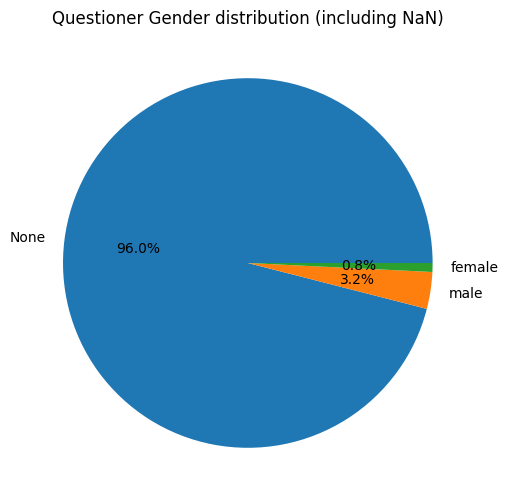

In [58]:
# Visualize the gender distribution of questioners, including missing values
if 'question_user_gender' in df.columns:
    q_gender_counts = df['question_user_gender'].value_counts(dropna=False)
    plt.figure(figsize=(6,6))
    q_gender_counts.plot(kind='pie', autopct='%1.1f%%', ylabel='')
    plt.title('Questioner Gender distribution (including NaN)')
    save_or_show(plt)


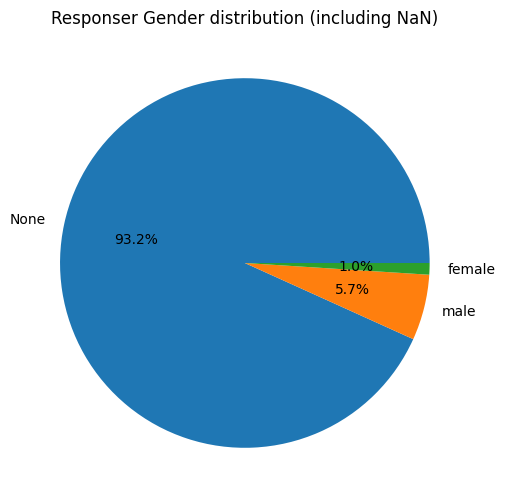

In [59]:
# Visualize the gender distribution of responders, including missing values
if 'response_user_gender' in df.columns:
    r_gender_counts = df['response_user_gender'].value_counts(dropna=False)
    plt.figure(figsize=(6,6))
    r_gender_counts.plot(kind='pie', autopct='%1.1f%%', ylabel='')
    plt.title('Responser Gender distribution (including NaN)')
    save_or_show(plt)


## 10) Additional chart suggestions + implementations


###   a) Response lag distribution (response_sent - question_sent) in hours


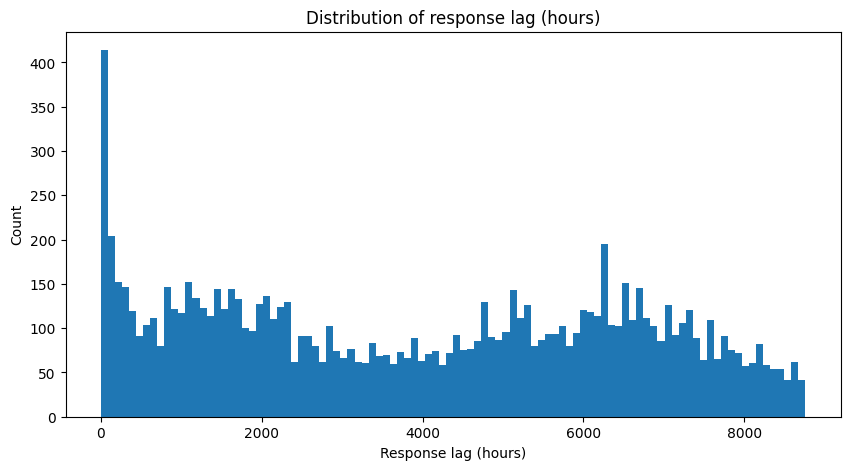

In [60]:
# Compute and visualize the distribution of response lag in hours between question and response
if 'response_sent' in df.columns and 'question_sent' in df.columns:
    df['response_lag_hours'] = (df['response_sent'] - df['question_sent']).dt.total_seconds() / 3600.0
    # Filter to reasonable lags (0 to 1 year)
    lag = df['response_lag_hours'].dropna()
    lag = lag[(lag >= 0) & (lag <= 24*365)]
    plt.figure(figsize=(10,5))
    plt.hist(lag, bins=100)
    plt.xlabel('Response lag (hours)')
    plt.ylabel('Count')
    plt.title('Distribution of response lag (hours)')
    save_or_show(plt)


### b) Monthly heatmap of question topics (topic x month



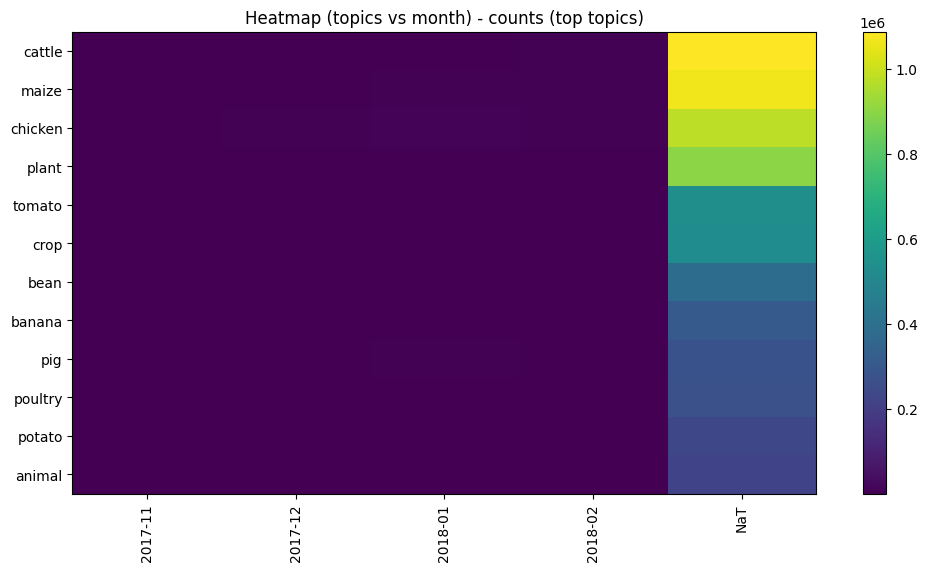

In [61]:
# Create a heatmap of question counts over months for the top 12 topics
df['q_month_str'] = df['q_date'].dt.to_period('M').astype(str)
topic_month = df.groupby(['question_topic','q_month_str'])['question_id'].count().unstack(fill_value=0)

# Select top 12 topics by total question count
top_topics = topic_month.sum(axis=1).sort_values(ascending=False).head(12).index
heat = topic_month.loc[top_topics]

plt.figure(figsize=(12,6))
plt.imshow(heat, aspect='auto')
plt.yticks(ticks=np.arange(len(heat.index)), labels=heat.index)
plt.xticks(ticks=np.arange(len(heat.columns)), labels=heat.columns, rotation=90)
plt.title('Heatmap (topics vs month) - counts (top topics)')
plt.colorbar()
save_or_show(plt)

###   c) Top N users (questions asked and responses given)

In [62]:
# Identify and display the top 10 most active questioners and responders by activity count
top_questioners = df['question_user_id'].value_counts().head(10)
top_responders = df['response_user_id'].value_counts().head(10)

print("Top 10 questioners (id: count):")
print(top_questioners)
print("Top 10 responders (id: count):")
print(top_responders)


Top 10 questioners (id: count):
question_user_id
730226     22268
3199006    16781
1061058    12835
853100     12373
3413249    11326
1206146    10390
607370      9251
793767      8958
679197      8632
2361792     6963
Name: count, dtype: int64
Top 10 responders (id: count):
response_user_id
1364605    23018
367428     13326
1254217    10501
202949      9719
1149700     8603
478338      8416
3413249     8335
1053962     8315
1019419     8139
1151861     7974
Name: count, dtype: int64


In [64]:
# Save key summary tables and indicate completion of EDA
summary = {
    'country_counts': country_counts,
    'unique_users_by_age': unique_both,
    'top_questioners': top_questioners,
    'top_responders': top_responders
}

# Optionally, save individual summaries to CSV or pickle for later use
# pd.DataFrame(country_counts).to_csv('country_counts.csv')

print("EDA complete. Generated the requested charts and prints.")


EDA complete. Generated the requested charts and prints.


In [67]:
for col in df.columns:
    if pd.api.types.is_categorical_dtype(df[col]):
        df[col] = df[col].astype(str)

df.to_parquet('/kaggle/working/df.parquet', index=False)


/tmp/ipykernel_47/857510726.py:2: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[col]):
/tmp/ipykernel_47/857510726.py:2: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[col]):


In [ ]:
profile = ProfileReport(df, title="EDA Report", explorative=True)
profile.to_notebook_iframe()


/tmp/ipykernel_269/2378400520.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


 11%|█         | 4/38 [06:33<55:09, 97.34s/it]   

# Challenge 1: Identifying patterns in weather and agriculture 

In [1]:
df = pd.read_parquet("/kaggle/input/df.parquet")

NameError: name 'pd' is not defined

In [69]:
# Taking the guidance setting for each countries and seasoning the patterns (q_month)
# Use question date (you can switch to response date if needed)
df['q_month_num'] = df['q_date'].dt.month

In [70]:
df['r_month_num'] = df['r_date'].dt.month

In [71]:
# Define country-specific farming seasons and corresponding month ranges for seasonality analysis
FARMING_SEASONS = {
    'KE': {
        'Long Rains (Planting)': [(3, 5)],
        'Short Rains (Planting)': [(10, 12)],
        'Harvest_1': [(6, 8)],
        'Harvest_2': [(1, 2)]
    },
    'UG': {
        'Season A (Planting)': [(3, 5)],
        'Season A (Harvest)': [(6, 8)],
        'Season B (Planting)': [(9, 11)],
        'Season B (Harvest)': [(12, 12), (1, 2)]
    },
    'TZ': {
        'Masika Rains (Planting)': [(3, 5)],
        'Vuli Rains (Planting)': [(10, 12)],
        'Harvest': [(6, 8)]
    },
    'GB': {
        'Spring Planting': [(3, 4)],
        'Growing Season': [(5, 8)],
        'Harvest': [(9, 10)]
    }
}


In [72]:
type(df['q_month'].iloc[0])  # pandas._libs.tslibs.period.Period


pandas._libs.tslibs.period.Period

In [73]:
# Map a given country and month to the corresponding farming season, handling cross-year ranges
def get_farming_season(country, month):
    if pd.isna(country) or pd.isna(month):
        return None

    country = str(country).upper()
    month = int(month)

    if country not in FARMING_SEASONS:
        return 'Other / Unknown'

    for season, ranges in FARMING_SEASONS[country].items():
        for start, end in ranges:
            if start <= end:
                if start <= month <= end:
                    return season
            else:
                # Handle cross-year seasons (e.g., Dec–Feb)
                if month >= start or month <= end:
                    return season

    return 'Off-season'


In [74]:
df['q_month_num'] = df['q_date'].dt.month
df['r_month_num'] = df['r_date'].dt.month


In [75]:
# Assign a farming season to each question based on the user's country and question month
df['Question_Farming_Season'] = [
    get_farming_season(c, m)
    for c, m in zip(df['question_user_country_code'], df['q_month_num'])
]


In [76]:
# Assign a farming season to each response based on the responder's country and response month
df['Response_Farming_Season'] = [
    get_farming_season(c, m)
    for c, m in zip(df['response_user_country_code'], df['r_month_num'])
]


In [77]:
df.groupby(
    ['question_user_country_code', 'q_month_num', 'Question_Farming_Season']
).size().head(20)

question_user_country_code  q_month_num  Question_Farming_Season
GB                          2.0          Off-season                    10
                            12.0         Off-season                     4
KE                          1.0          Harvest_2                  31202
                            2.0          Harvest_2                  41407
                            11.0         Short Rains (Planting)     14436
                            12.0         Short Rains (Planting)     31561
TZ                          12.0         Vuli Rains (Planting)          2
UG                          1.0          Season B (Harvest)         37911
                            2.0          Season B (Harvest)         17850
                            11.0         Season B (Planting)         8343
                            12.0         Season B (Harvest)         23621
dtype: int64

In [83]:
# Aggregate monthly question volume by country and farming season
seasonal_qvolume= ( 
    df.groupby([ 'question_user_country_code','Question_Farming_Season',
                'q_month_num'
               ]) 
    .agg(
        question_count= ('question_id', 'count') 
    ) 
    .reset_index() 
)

In [84]:
seasonal_qvolume

question_user_country_code Question_Farming_Season  q_month_num  \
0                          GB              Off-season          2.0   
1                          GB              Off-season         12.0   
2                          KE               Harvest_2          1.0   
3                          KE               Harvest_2          2.0   
4                          KE  Short Rains (Planting)         11.0   
5                          KE  Short Rains (Planting)         12.0   
6                          TZ   Vuli Rains (Planting)         12.0   
7                          UG      Season B (Harvest)          1.0   
8                          UG      Season B (Harvest)          2.0   
9                          UG      Season B (Harvest)         12.0   
10                         UG     Season B (Planting)         11.0   

    question_count  
0               10  
1                4  
2            31202  
3            41407  
4            14436  
5            31561  
6                2  
7            37911  
8            17850  
9            23621  
10            8343

In [85]:
# Aggregate monthly response volume by country and farming season
seasonal_rvolume = (
    df.groupby([
        'response_user_country_code','Response_Farming_Season',
        'r_month_num'
    ])
    .agg(
        response_count=('response_id', 'count')
    )
    .reset_index()
)


In [86]:
seasonal_rvolume

response_user_country_code  Response_Farming_Season  r_month_num  \
0                          gb           Growing Season          5.0   
1                          gb           Growing Season          6.0   
2                          gb           Growing Season          7.0   
3                          gb           Growing Season          8.0   
4                          gb                  Harvest          9.0   
5                          gb                  Harvest         10.0   
6                          gb               Off-season          1.0   
7                          gb               Off-season          2.0   
8                          gb               Off-season         11.0   
9                          gb               Off-season         12.0   
10                         gb          Spring Planting          3.0   
11                         gb          Spring Planting          4.0   
12                         ke                Harvest_1          6.0   
13                         ke                Harvest_1          7.0   
14                         ke                Harvest_1          8.0   
15                         ke                Harvest_2          1.0   
16                         ke                Harvest_2          2.0   
17                         ke    Long Rains (Planting)          3.0   
18                         ke    Long Rains (Planting)          4.0   
19                         ke    Long Rains (Planting)          5.0   
20                         ke               Off-season          9.0   
21                         ke   Short Rains (Planting)         10.0   
22                         ke   Short Rains (Planting)         11.0   
23                         ke   Short Rains (Planting)         12.0   
24                         tz  Masika Rains (Planting)          3.0   
25                         tz               Off-season          1.0   
26                         tz               Off-season          9.0   
27                         tz    Vuli Rains (Planting)         10.0   
28                         ug       Season A (Harvest)          6.0   
29                         ug       Season A (Harvest)          7.0   
30                         ug       Season A (Harvest)          8.0   
31                         ug      Season A (Planting)          3.0   
32                         ug      Season A (Planting)          4.0   
33                         ug      Season A (Planting)          5.0   
34                         ug       Season B (Harvest)          1.0   
35                         ug       Season B (Harvest)          2.0   
36                         ug       Season B (Harvest)         12.0   
37                         ug      Season B (Planting)          9.0   
38                         ug      Season B (Planting)         10.0   
39                         ug      Season B (Planting)         11.0   

    response_count  
0                6  
1                4  
2               25  
3               22  
4               71  
5               28  
6               25  
7                5  
8               11  
9                4  
10              50  
11              11  
12          437276  
13          393089  
14          879288  
15          296569  
16          280223  
17          447225  
18          619208  
19          582591  
20          765437  
21          652387  
22          883459  
23          772046  
24               1  
25               2  
26               1  
27               1  
28          231496  
29          334355  
30          626468  
31          244521  
32          337871  
33          312810  
34          195802  
35          241234  
36          391432  
37          479795  
38          425725  
39          499699

In [89]:
# Sort for plotting
seasonal_qvolume = seasonal_qvolume.sort_values(['question_user_country_code', 'Question_Farming_Season', 'q_month_num'])


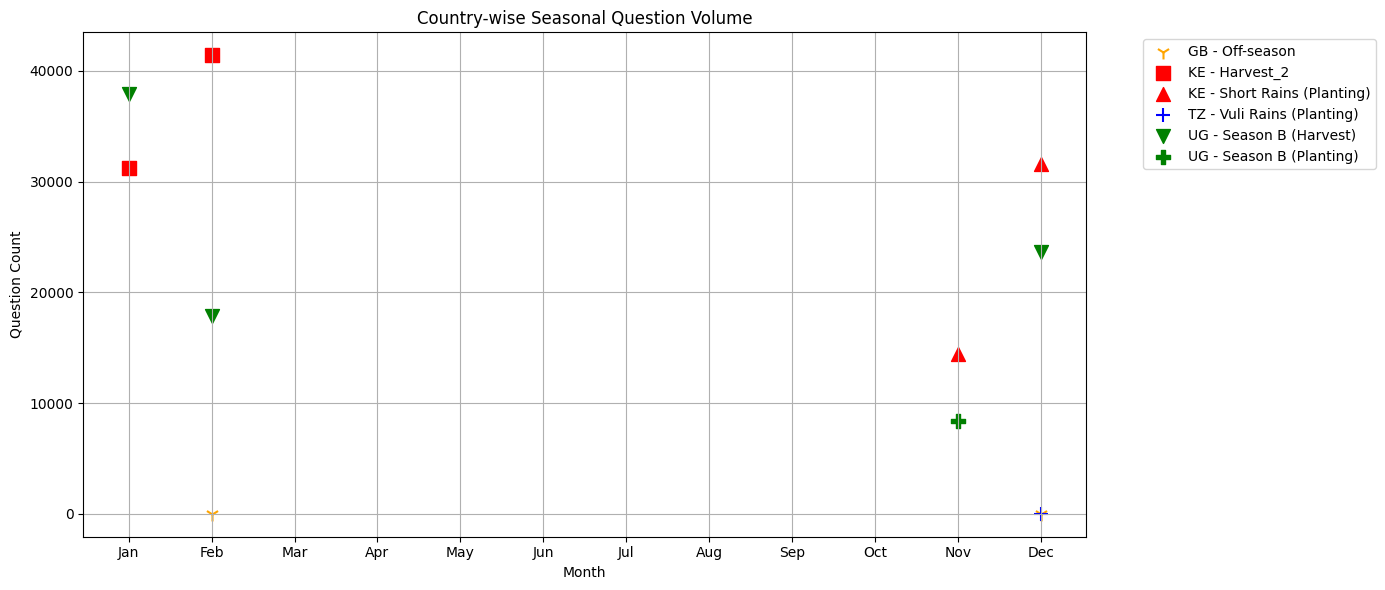

In [90]:
# Map month numbers to month names
MONTH_MAP = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr",
             5: "May", 6: "Jun", 7: "Jul", 8: "Aug",
             9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
seasonal_qvolume['month_name'] = seasonal_qvolume['q_month_num'].map(MONTH_MAP)

# Normalize country codes (uppercase, no spaces)
seasonal_qvolume['question_user_country_code'] = seasonal_qvolume['question_user_country_code'].str.upper().str.strip()

# Define colors for countries
colors = {
    'KE': 'red',
    'UG': 'green',
    'TZ': 'blue',
    'GB': 'orange'
}

# Define marker shapes for seasons
season_markers = {
    'Harvest_1': 'o', 'Harvest_2': 's', 'Short Rains (Planting)': '^',
    'Long Rains (Planting)': '*', 'Season A (Planting)': 'D',
    'Season B (Planting)': 'P', 'Season A (Harvest)': 'X',
    'Season B (Harvest)': 'v', 'Masika Rains (Planting)': 'h',
    'Vuli Rains (Planting)': '+', 'Off-season': '1'
}

# Plot scatter for questions
plt.figure(figsize=(14, 6))

for country in seasonal_qvolume['question_user_country_code'].unique():
    country_df = seasonal_qvolume[seasonal_qvolume['question_user_country_code'] == country]
    for season in country_df['Question_Farming_Season'].unique():
        s = country_df[country_df['Question_Farming_Season'] == season]
        plt.scatter(
            s['q_month_num'],
            s['question_count'],
            color=colors.get(country, 'black'),  # country color
            marker=season_markers.get(season, 'o'),  # season marker
            s=100,
            label=f"{country} - {season}"
        )

plt.xticks(range(1, 13), [MONTH_MAP[i] for i in range(1, 13)])
plt.xlabel("Month")
plt.ylabel("Question Count")
plt.title("Country-wise Seasonal Question Volume")
plt.grid(True)

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("images/Country-wise Seasonal Question Volume.png")
plt.show()


# Challenge 2: Seasonality 

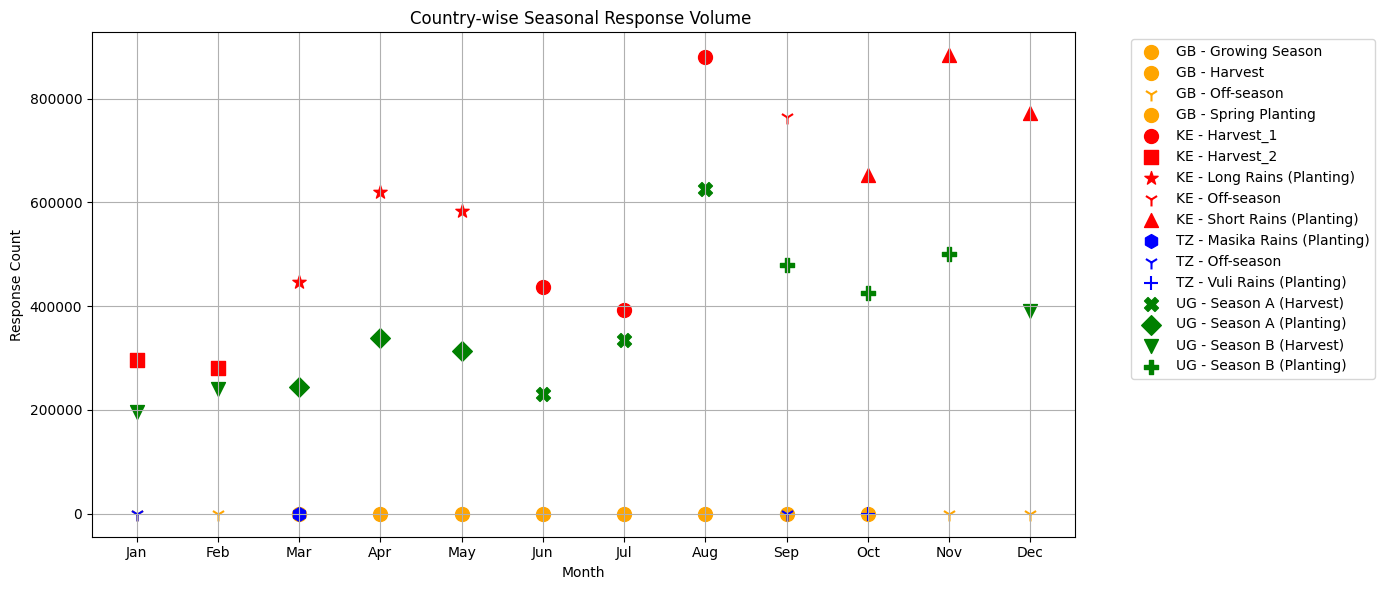

In [91]:
# Map month numbers to month names
MONTH_MAP = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr",
             5: "May", 6: "Jun", 7: "Jul", 8: "Aug",
             9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
seasonal_rvolume['month_name'] = seasonal_rvolume['r_month_num'].map(MONTH_MAP)

# Normalize country codes (uppercase, no spaces)
seasonal_rvolume['response_user_country_code'] = seasonal_rvolume['response_user_country_code'].str.upper().str.strip()

# Define colors for countries
colors = {
    'KE': 'red',
    'UG': 'green',
    'TZ': 'blue',
    'GB': 'orange'
}

# Define marker shapes for seasons
season_markers = {
    'Harvest_1': 'o', 'Harvest_2': 's', 'Short Rains (Planting)': '^',
    'Long Rains (Planting)': '*', 'Season A (Planting)': 'D',
    'Season B (Planting)': 'P', 'Season A (Harvest)': 'X',
    'Season B (Harvest)': 'v', 'Masika Rains (Planting)': 'h',
    'Vuli Rains (Planting)': '+', 'Off-season': '1'
}

# Plot scatter
plt.figure(figsize=(14, 6))

for country in seasonal_rvolume['response_user_country_code'].unique():
    country_df = seasonal_rvolume[seasonal_rvolume['response_user_country_code'] == country]
    for season in country_df['Response_Farming_Season'].unique():
        s = country_df[country_df['Response_Farming_Season'] == season]
        plt.scatter(
            s['r_month_num'],
            s['response_count'],
            color=colors.get(country, 'black'),  # now will use correct color
            marker=season_markers.get(season, 'o'),
            s=100,
            label=f"{country} - {season}"
        )

plt.xticks(range(1, 13), [MONTH_MAP[i] for i in range(1, 13)])
plt.xlabel("Month")
plt.ylabel("Response Count")
plt.title("Country-wise Seasonal Response Volume ")
plt.grid(True)

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("images/Country-wise Seasonal Response Volume.png")

plt.show()


# Challenge 3: Identifying Community Leaders 

In [92]:
# Create response length as a proxy for quality
df['response_length'] = df['response_content'].str.len()

# Flag if response topic matches question topic (1 = match, 0 = no match)
df['topic_match'] = (df['response_topic'] == df['question_topic']).astype(int)

# Compute a simple quality score (weighted)
df['response_quality_score'] = df['response_length'] * 0.7 + df['topic_match'] * 100

In [93]:
df['topic_match'].sort_values(ascending= False)

1772027     1
7113854     1
10357844    1
1369228     1
8023158     1
           ..
4163129     0
4163130     0
4163131     0
4163132     0
11523992    0
Name: topic_match, Length: 11523993, dtype: int64

df[
    [
        'question_id',
        'question_topic',
        'response_id',
        'response_topic',
        'topic_match'
    ]
].head(20)


In [94]:
df[['response_length','topic_match', 'question_topic', 'response_topic']]

response_length  topic_match question_topic response_topic
0                      41            0           None           None
1                      11            0         rabbit           None
2                     127            0        poultry           None
3                      87            0            pig           None
4                      17            0        coconut         cereal
...                   ...          ...            ...            ...
11523988               76            0          plant        chicken
11523989                1            0        cabbage           None
11523990               34            0          maize           None
11523991               34            0           bird           None
11523992               60            0         tomato           None

[11523993 rows x 4 columns]

In [95]:
df['topic_match'] = (df['response_topic'] == df['question_topic']).astype(int)

In [96]:
monthly_leaderboard = df.groupby([
    'response_user_country_code', 'response_user_id', 'r_year', 'r_month'
]).agg(
    total_responses=('response_id', 'count'),
    total_quality_score=('response_quality_score', 'sum'),
    avg_response_score=('response_quality_score', 'mean')
).reset_index()

# Rank responders by total_quality_score within each country and month
monthly_leaderboard['monthly_rank'] = monthly_leaderboard.groupby(
    ['response_user_country_code', 'r_year', 'r_month']
)['total_quality_score'].rank(method='dense', ascending=False)

monthly_leaderboard

response_user_country_code  response_user_id  r_year  r_month  \
0                               gb                10  2018.0  2018-07   
1                               gb             82791  2018.0  2018-03   
2                               gb             82791  2018.0  2018-06   
3                               gb             82791  2018.0  2018-09   
4                               gb             82791  2018.0  2018-11   
...                            ...               ...     ...      ...   
1753051                         ug           3733145  2021.0  2021-09   
1753052                         ug           3733198  2021.0  2021-09   
1753053                         ug           3733206  2021.0  2021-09   
1753054                         ug           3733229  2021.0  2021-09   
1753055                         ug           3733254  2021.0  2021-09   

         total_responses  total_quality_score  avg_response_score  \
0                      2                 67.2              33.600   
1                      1                  4.9               4.900   
2                      1                 11.9              11.900   
3                      1                 23.8              23.800   
4                      2                 37.1              18.550   
...                  ...                  ...                 ...   
1753051                5                173.6              34.720   
1753052                1                  4.2               4.200   
1753053                8                107.8              13.475   
1753054                1                 31.5              31.500   
1753055                1                 24.5              24.500   

         monthly_rank  
0                 2.0  
1                 6.0  
2                 1.0  
3                 5.0  
4                 5.0  
...               ...  
1753051        1537.0  
1753052        2103.0  
1753053        1830.0  
1753054        2036.0  
1753055        2055.0  

[1753056 rows x 8 columns]

In [97]:
yearly_leaderboard = df.groupby([
    'response_user_country_code', 'response_user_id', 'r_year'
]).agg(
    total_responses=('response_id', 'count'),
    total_quality_score=('response_quality_score', 'sum'),
    avg_response_score=('response_quality_score', 'mean')
).reset_index()

# Rank by total_quality_score within country and year
yearly_leaderboard['yearly_rank'] = yearly_leaderboard.groupby(
    ['response_user_country_code', 'r_year']
)['total_quality_score'].rank(method='dense', ascending=False)

yearly_leaderboard


response_user_country_code  response_user_id  r_year  total_responses  \
0                              gb                10  2018.0                2   
1                              gb             82791  2018.0                5   
2                              gb             82791  2019.0                5   
3                              gb             82791  2020.0                1   
4                              gb            232982  2018.0                2   
...                           ...               ...     ...              ...   
690560                         ug           3733145  2021.0                5   
690561                         ug           3733198  2021.0                1   
690562                         ug           3733206  2021.0                8   
690563                         ug           3733229  2021.0                1   
690564                         ug           3733254  2021.0                1   

        total_quality_score  avg_response_score  yearly_rank  
0                      67.2              33.600         14.0  
1                      77.7              15.540         13.0  
2                     227.5              45.500          9.0  
3                     120.3             120.300         11.0  
4                     142.7              71.350          9.0  
...                     ...                 ...          ...  
690560                173.6              34.720       9807.0  
690561                  4.2               4.200      10453.0  
690562                107.8              13.475      10153.0  
690563                 31.5              31.500      10377.0  
690564                 24.5              24.500      10397.0  

[690565 rows x 7 columns]

In [98]:
gender_leaderboard = df.groupby([
    'response_user_country_code', 'response_user_gender'
]).agg(
    total_responses=('response_id', 'count'),
    total_quality_score=('response_quality_score', 'sum'),
    avg_response_score=('response_quality_score', 'mean')
).reset_index()

# Rank gender within each country
gender_leaderboard['gender_rank'] = gender_leaderboard.groupby(
    'response_user_country_code'
)['total_quality_score'].rank(method='dense', ascending=False)
gender_leaderboard

response_user_country_code response_user_gender  total_responses  \
0                         gb               female                1   
1                         gb                 male                8   
2                         ke               female            92524   
3                         ke                 male           503539   
4                         ug               female            24115   
5                         ug                 male           158962   

   total_quality_score  avg_response_score  gender_rank  
0                 25.2           25.200000          2.0  
1                764.9           95.612500          1.0  
2            4012473.4           43.366839          2.0  
3           28164897.5           55.933895          1.0  
4            1163429.8           48.245067          2.0  
5            8371941.2           52.666305          1.0

In [99]:
season_leaderboard = df.groupby([
    'response_user_country_code', 'Response_Farming_Season'
]).agg(
    total_responses=('response_id', 'count'),
    total_quality_score=('response_quality_score', 'sum')
).reset_index()


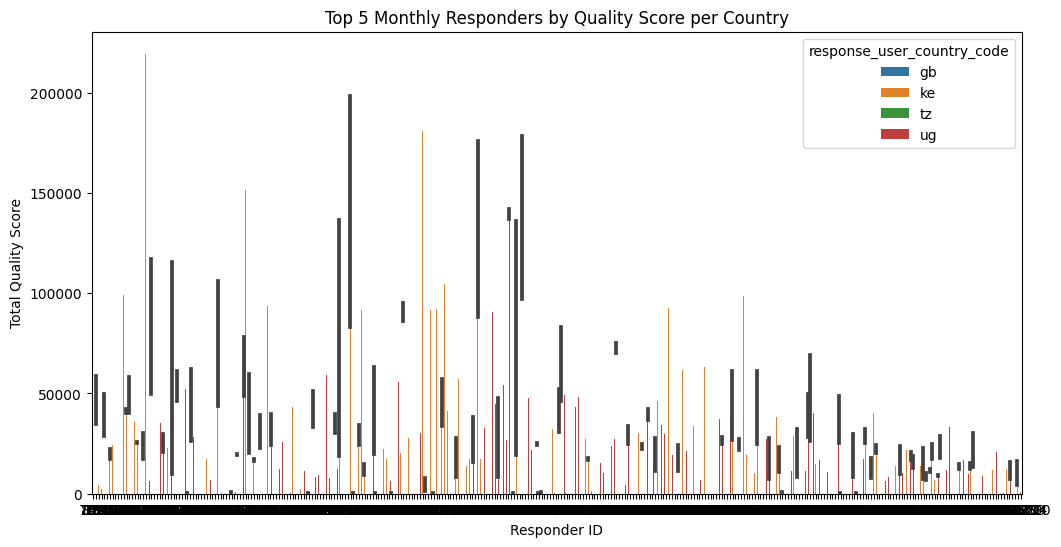

In [100]:
top_monthly = monthly_leaderboard[monthly_leaderboard['monthly_rank'] <= 5]

plt.figure(figsize=(12,6))
sns.barplot(
    data=top_monthly,
    x='response_user_id',
    y='total_quality_score',
    hue='response_user_country_code'
)
plt.title("Top 5 Monthly Responders by Quality Score per Country")
plt.xlabel("Responder ID")
plt.ylabel("Total Quality Score")
plt.savefig("images/Top 5 Monthly Responders by Quality Score per Country.png")
plt.show()


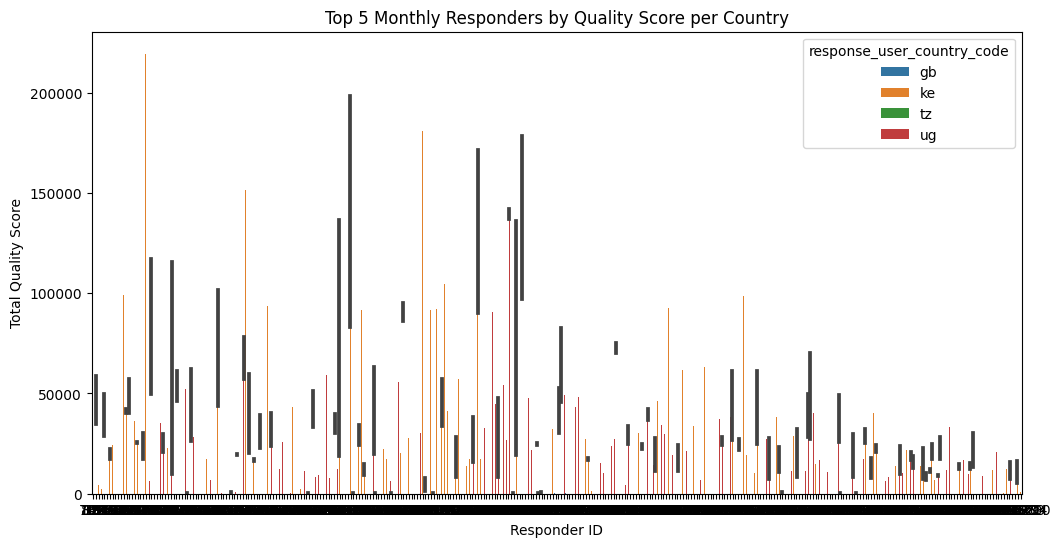

In [101]:
top_yearly= yearly_leaderboard[yearly_leaderboard['yearly_rank'] <= 5]

plt.figure(figsize=(12,6))
sns.barplot(
    data=top_monthly,
    x='response_user_id',
    y='total_quality_score',
    hue='response_user_country_code'
)
plt.title("Top 5 Monthly Responders by Quality Score per Country")
plt.xlabel("Responder ID")
plt.ylabel("Total Quality Score")
plt.savefig("images/Top 5 Monthly Responders by Quality Score per Country.png")
plt.show()


plt.figure(figsize=(16,9))
sns.barplot(
    data=top_monthly,
    x='response_user_id',
    y='total_quality_score',
    hue='response_user_country_code',
    ci=None            # legacy fix
)


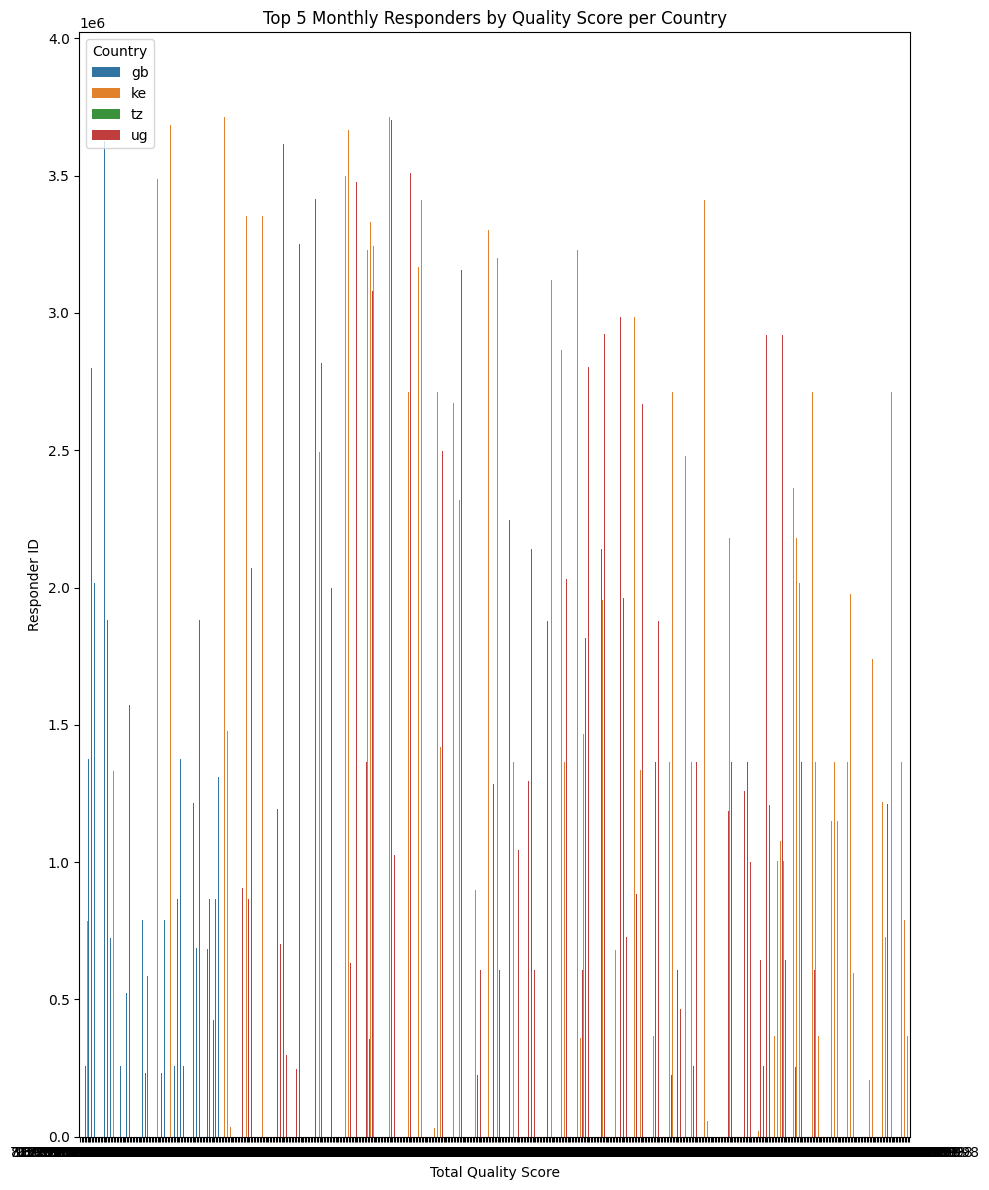

In [27]:
plt.figure(figsize=(10,12))

sns.barplot(
    data=top_monthly,
    y='response_user_id',
    x='total_quality_score',
    hue='response_user_country_code',
    errorbar=None
)

plt.title("Top 5 Monthly Responders by Quality Score per Country")
plt.xlabel("Total Quality Score")
plt.ylabel("Responder ID")
plt.legend(title='Country')
plt.tight_layout()
plt.savefig("images/Top 5 Monthly Responders by Quality Score per Country.png")
plt.show()


In [61]:
# Monthly quality score per responder
monthly_leaders = (
    df
    .dropna(subset=['response_user_id', 'r_month'])
    .groupby(['r_month', 'response_user_id'])
    ['response_quality_score']
    .sum()
    .reset_index()
)

# Select top 5 leaders overall
top_leaders = (
    monthly_leaders
    .groupby('response_user_id')['response_quality_score']
    .sum()
    .nlargest(5)
    .index
)

monthly_leaders = monthly_leaders[
    monthly_leaders['response_user_id'].isin(top_leaders)
]


In [62]:
leader_score = df.groupby(
    ['response_user_country_code', 'response_user_id']
).agg(
    total_responses=('response_id', 'count'),
    avg_quality=('response_quality_score', 'mean'),
    seasons_active=('Response_Farming_Season', 'nunique')
).reset_index()

leader_score['leader_index'] = (
    leader_score['avg_quality'] * 0.6 +
    leader_score['seasons_active'] * 20 +
    leader_score['total_responses'] * 0.1
)

leader_score

response_user_country_code  response_user_id  total_responses  \
0                              gb                10                4   
1                              gb             82791               14   
2                              gb            232982               18   
3                              gb            253116                6   
4                              gb            256838                8   
...                           ...               ...              ...   
446899                         ug           3733145                5   
446900                         ug           3733198                1   
446901                         ug           3733206                8   
446902                         ug           3733229                1   
446903                         ug           3733254                1   

        avg_quality  seasons_active  leader_index  
0         57.550000               1     54.930000  
1         40.685714               4    105.811429  
2         30.205556               4     99.923333  
3         30.683333               4     99.010000  
4         95.612500               2     98.167500  
...             ...             ...           ...  
446899    34.720000               1     41.332000  
446900     4.200000               1     22.620000  
446901    13.475000               1     28.885000  
446902    31.500000               1     39.000000  
446903    24.500000               1     34.800000  

[446904 rows x 6 columns]

In [63]:
# Country-wise leader aggregation
country_leaders = df.groupby(
    ['response_user_country_code', 'response_user_id']
).agg(
    total_responses=('response_id', 'count'),
    total_quality_score=('response_quality_score', 'sum'),
    avg_quality_score=('response_quality_score', 'mean'),
    active_years=('r_year', 'nunique'),
    active_seasons=('Response_Farming_Season', 'nunique')
).reset_index()

country_leaders

response_user_country_code  response_user_id  total_responses  \
0                              gb                10                4   
1                              gb             82791               14   
2                              gb            232982               18   
3                              gb            253116                6   
4                              gb            256838                8   
...                           ...               ...              ...   
446899                         ug           3733145                5   
446900                         ug           3733198                1   
446901                         ug           3733206                8   
446902                         ug           3733229                1   
446903                         ug           3733254                1   

        total_quality_score  avg_quality_score  active_years  active_seasons  
0                     230.2          57.550000             1               1  
1                     569.6          40.685714             3               4  
2                     543.7          30.205556             3               4  
3                     184.1          30.683333             3               4  
4                     764.9          95.612500             2               2  
...                     ...                ...           ...             ...  
446899                173.6          34.720000             1               1  
446900                  4.2           4.200000             1               1  
446901                107.8          13.475000             1               1  
446902                 31.5          31.500000             1               1  
446903                 24.5          24.500000             1               1  

[446904 rows x 7 columns]

In [64]:
country_leaders['leader_index'] = (
    country_leaders['avg_quality_score'] * 0.5 +
    country_leaders['active_seasons'] * 20 +
    country_leaders['total_responses'] * 0.1
)


In [65]:
country_leaders['rank'] = country_leaders.groupby(
    'response_user_country_code'
)['leader_index'].rank(method='dense', ascending=False)

top10_country_leaders = country_leaders[country_leaders['rank'] <= 10] \
    .sort_values(['response_user_country_code', 'rank'])

In [66]:
top10_country_leaders[
    ['response_user_country_code', 'rank', 'response_user_id',
     'leader_index', 'total_responses', 'avg_quality_score']
]

response_user_country_code  rank  response_user_id  leader_index  \
24                             gb   1.0           1310965    140.150000   
29                             gb   2.0           1883256    136.737500   
18                             gb   3.0            867546    132.280556   
5                              gb   4.0            258508    128.405882   
21                             gb   5.0           1216551    125.221429   
26                             gb   6.0           1311171    124.750000   
27                             gb   7.0           1349074    121.933333   
10                             gb   8.0            414252    113.533333   
14                             gb   9.0            791004    112.190909   
43                             gb  10.0           2923072    104.615000   
123842                         ke   1.0           1364605   2440.925382   
31228                          ke   2.0            367428   1489.033934   
111022                         ke   3.0           1254217   1175.494786   
22321                          ke   4.0            202949   1089.798652   
97308                          ke   5.0           1149700   1027.377711   
243853                         ke   6.0           3413249    950.965285   
86951                          ke   7.0           1053962    949.163013   
82345                          ke   8.0           1019419    934.035723   
97928                          ke   9.0           1151861    928.986280   
59245                          ke  10.0            793767    849.776506   
256145                         tz   1.0            583687     70.580000   
279138                         ug   1.0            478338    942.529408   
286353                         ug   2.0            607370    864.465984   
327518                         ug   3.0           1362926    776.055391   
319608                         ug   4.0           1212378    655.633172   
403486                         ug   5.0           2920179    603.907901   
291840                         ug   6.0            701231    548.080814   
305764                         ug   7.0           1000904    539.901815   
285619                         ug   8.0            593932    516.807918   
316937                         ug   9.0           1182924    513.207958   
408283                         ug  10.0           2984575    499.675391   

        total_responses  avg_quality_score  
24                    6         199.100000  
29                    8         151.875000  
18                   18         100.961111  
5                    17          93.411765  
21                    7          89.042857  
26                    1         209.300000  
27                    3         163.266667  
10                    9         145.266667  
14                   22          59.981818  
43                   20          45.230000  
123842            23018          78.250765  
31228             13326         112.867867  
111022            10501          50.789572  
22321              9719          35.797304  
97308              8603         134.155423  
243853             8335          34.930570  
86951              8315          35.326025  
82345              8139          40.271446  
97928              7974          63.172561  
59245              7323          34.953011  
256145                5          20.160000  
279138             8416          41.858817  
286353             7470          74.931968  
327518             6566          78.910783  
319608             5672          56.866343  
403486             4911          65.615801  
291840             4571          21.961628  
305764             4628          34.203630  
285619             4275          18.615836  
316937             4103          45.815915  
408283             4090          21.350782

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_47/1658335962.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


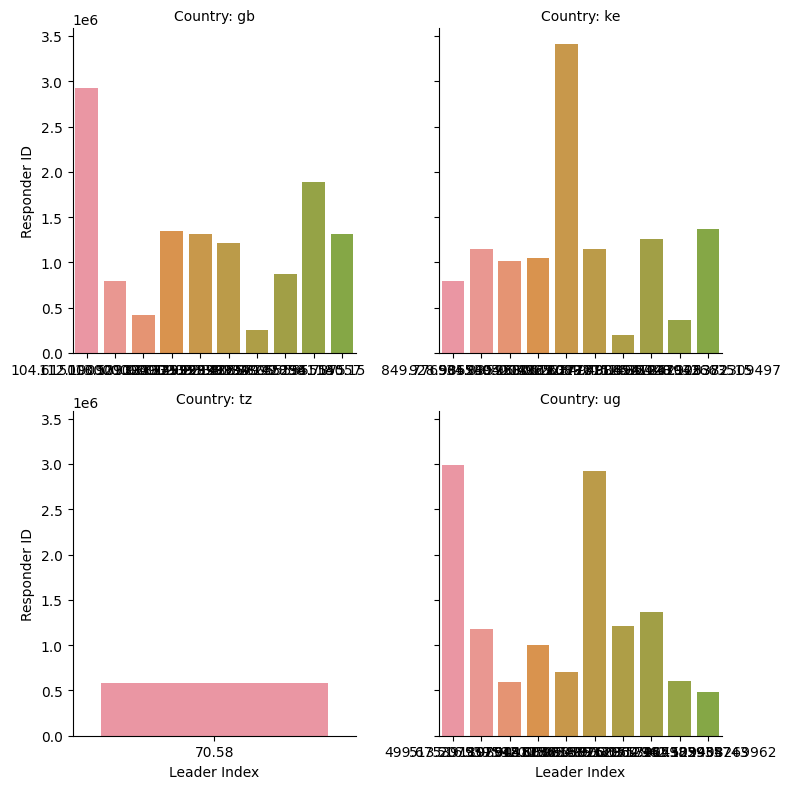

In [70]:
g = sns.catplot(
    data=top10_country_leaders,
    x='leader_index',
    y='response_user_id',
    col='response_user_country_code',
    kind='bar',
    col_wrap=2,
    height=4,
    sharex=False
)

g.set_titles("Country: {col_name}")
g.set_axis_labels("Leader Index", "Responder ID")
plt.tight_layout()
plt.savefig("images/Country-leaders.png")
plt.show()


# Relationship between Questions and Answers 

In [102]:
# Sample to keep it readable
sample_df = df[
    ['question_user_id', 'response_user_id']
].dropna().sample(5000, random_state=42)


In [103]:
G = nx.Graph()

# Add edges: Questioner -> Responder
for _, row in sample_df.iterrows():
    G.add_edge(
        f"Q_{row['question_user_id']}",
        f"R_{row['response_user_id']}"
    )


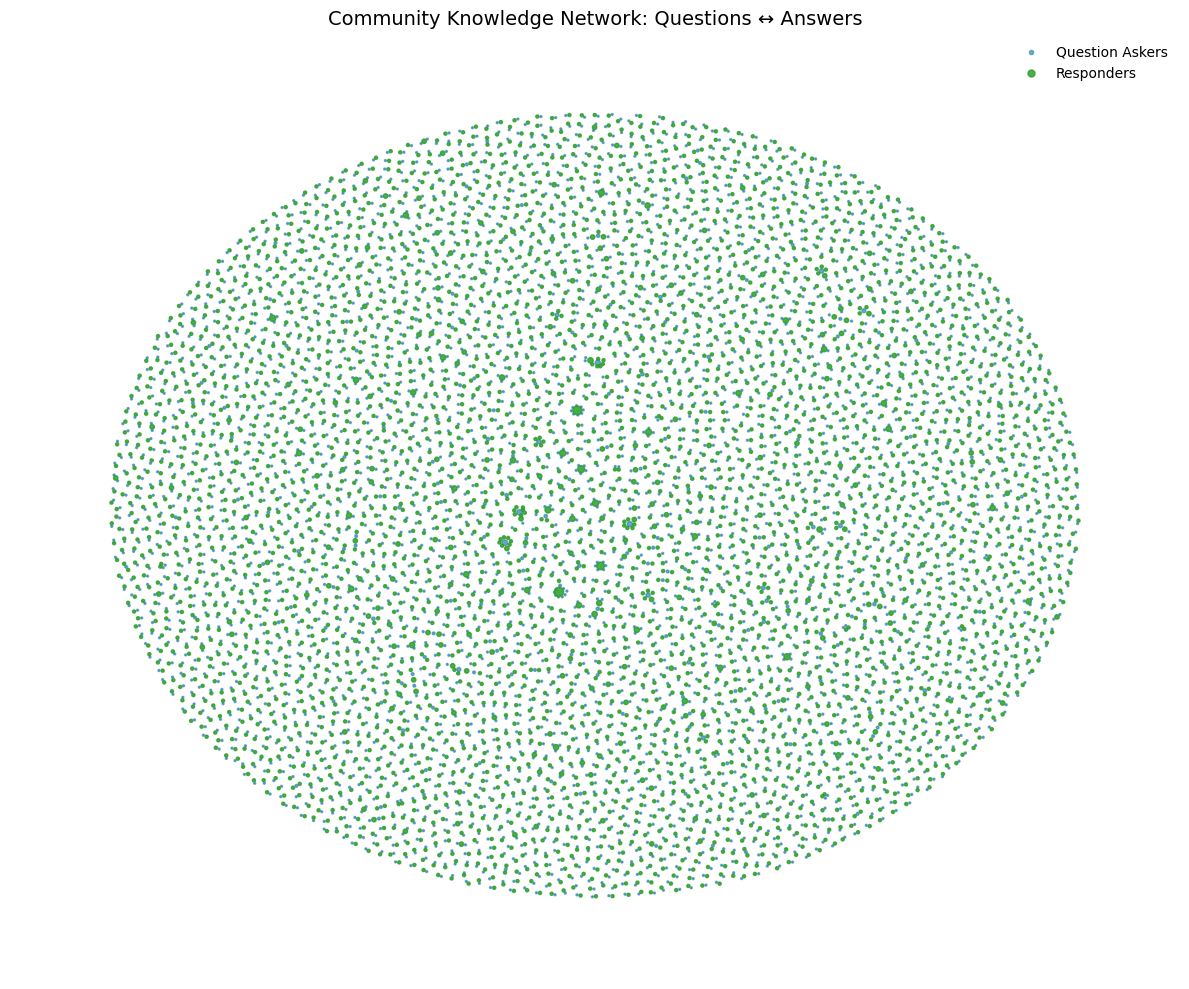

In [104]:
plt.figure(figsize=(12,10))

# Layout
pos = nx.spring_layout(G, k=0.15, seed=42)

# Separate node types
q_nodes = [n for n in G.nodes if n.startswith('Q_')]
r_nodes = [n for n in G.nodes if n.startswith('R_')]

# Node sizes by influence (degree)
q_sizes = [G.degree(n) * 2 for n in q_nodes]
r_sizes = [G.degree(n) * 5 for n in r_nodes]

# Draw questioners (farmers)
nx.draw_networkx_nodes(
    G, pos,
    nodelist=q_nodes,
    node_size=q_sizes,
    node_color="#1f77b4",
    alpha=0.6,
    label="Question Askers"
)

# Draw responders (experts)
nx.draw_networkx_nodes(
    G, pos,
    nodelist=r_nodes,
    node_size=r_sizes,
    node_color="#2ca02c",
    alpha=0.85,
    label="Responders"
)

# Draw edges
nx.draw_networkx_edges(
    G, pos,
    alpha=0.08,
    edge_color="gray"
)

# Title & legend
plt.title("Community Knowledge Network: Questions ↔ Answers", fontsize=14)
plt.legend(scatterpoints=1, frameon=False)
plt.axis("off")
plt.tight_layout()
plt.show()


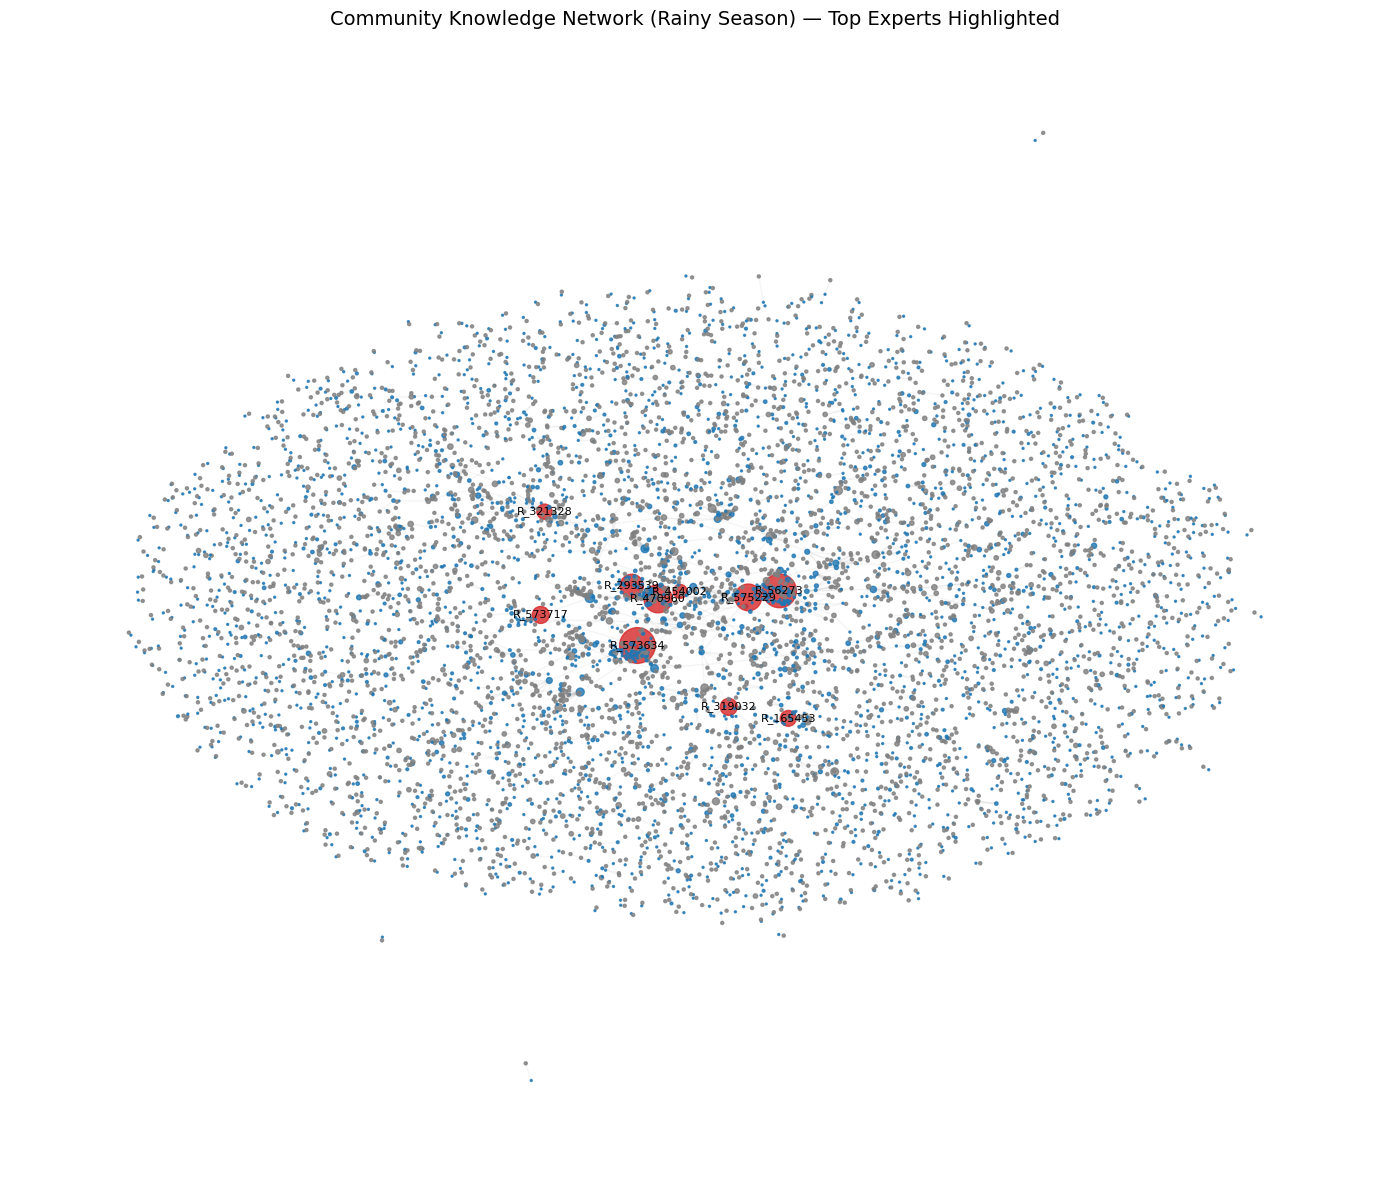

In [41]:
# Assume 'q_month_num' exists and 1-12
# Filter to rainy season months for demonstration
rainy_months = [3,4,5,10,11,12]  # Kenya/Tanzania/Uganda rainy months
df_rainy = df[df['q_month_num'].isin(rainy_months)]

# Keep only non-null question/response
df_rainy = df_rainy.dropna(subset=['question_user_id','response_user_id','question_user_country_code','response_user_country_code'])

# Sample for network visualization
sample_df = df_rainy.sample(5000, random_state=42)

# -------------------------------
# 2️⃣ Build network
# -------------------------------
G = nx.Graph()
for _, row in sample_df.iterrows():
    G.add_edge(
        f"Q_{row['question_user_id']}",
        f"R_{row['response_user_id']}",
        country=row['response_user_country_code']
    )

# -------------------------------
# 3️⃣ Identify top 10 responders by degree
# -------------------------------
responder_nodes = [n for n in G.nodes if n.startswith('R_')]
top_responders = sorted(responder_nodes, key=lambda x: G.degree(x), reverse=True)[:10]

# -------------------------------
# 4️⃣ Assign node attributes
# -------------------------------
node_colors = []
node_sizes = []

for node in G.nodes:
    if node.startswith('Q_'):
        node_colors.append('#1f77b4')  # Blue = farmers
        node_sizes.append(G.degree(node)*2)
    else:
        # Top 10 experts highlighted larger
        if node in top_responders:
            node_colors.append('#d62728')  # Red = top expert
            node_sizes.append(G.degree(node)*10)
        else:
            # Other responders colored by country
            country = G.edges[list(G.edges(node))[0]]['country']
            color_map = {'KE':'#2ca02c','UG':'#ff7f0e','TZ':'#9467bd'}
            node_colors.append(color_map.get(country,'grey'))
            node_sizes.append(G.degree(node)*5)

# -------------------------------
# 5️⃣ Layout and draw
# -------------------------------
plt.figure(figsize=(14,12))
pos = nx.spring_layout(G, k=0.15, seed=42)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.08, edge_color='gray')

# Optional: Label only top responders
labels = {n:n for n in top_responders}
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='black')

plt.title("Community Knowledge Network (Rainy Season) — Top Experts Highlighted", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig('Community Knowledge Network-Top Experts')
plt.show()

### In this network, blue nodes represent farmers who asked questions. Responders are colored by country: green for Kenya, orange for Uganda, purple for Tanzania, with the top 10 experts highlighted in red. Node size reflects how many connections each user has, emphasizing the most influential community members.

# Challenge 4: Crop-Specific vs. Crop-Independent Questions 

In [105]:
# Define keywords for classification
pest_keywords = ['pest','insect','disease','weevil']
soil_keywords = ['soil','erosion','fertility','manure']
weather_keywords = ['rain','drought','temperature','weather','flood']
harvest_keywords = ['harvest','yield','storage','post-harvest']

# Simple function to classify topic
def classify_question(text):
    text_lower = str(text).lower()
    if any(k in text_lower for k in pest_keywords):
        return 'Pest'
    elif any(k in text_lower for k in soil_keywords):
        return 'Soil'
    elif any(k in text_lower for k in weather_keywords):
        return 'Weather'
    elif any(k in text_lower for k in harvest_keywords):
        return 'Harvest'
    else:
        # Check for crop-specific keywords (e.g., maize, tea, coffee)
        crop_keywords = ['maize','tea','coffee','wheat','rice','sorghum']
        if any(k in text_lower for k in crop_keywords):
            return 'Crop-Specific'
        else:
            return 'General'

# Apply classification
df['question_type'] = df['question_content'].apply(classify_question)


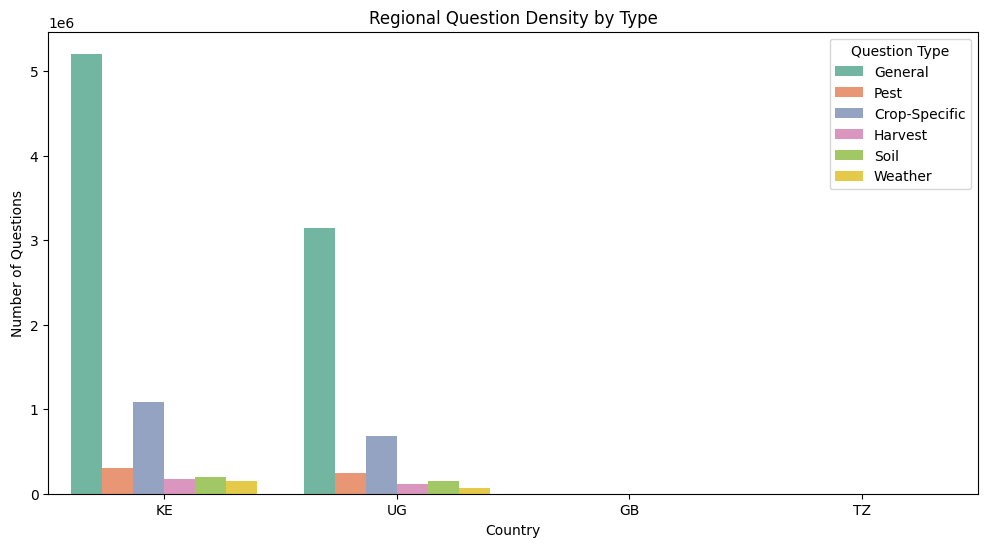

In [106]:
plt.figure(figsize=(12,6))
sns.countplot(
    data=df,
    x='question_user_country_code',
    hue='question_type',
    order=df['question_user_country_code'].value_counts().index,
    palette='Set2'
)
plt.title("Regional Question Density by Type")
plt.xlabel("Country")
plt.ylabel("Number of Questions")
plt.legend(title="Question Type")
plt.savefig("Regional Question Density by Type")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

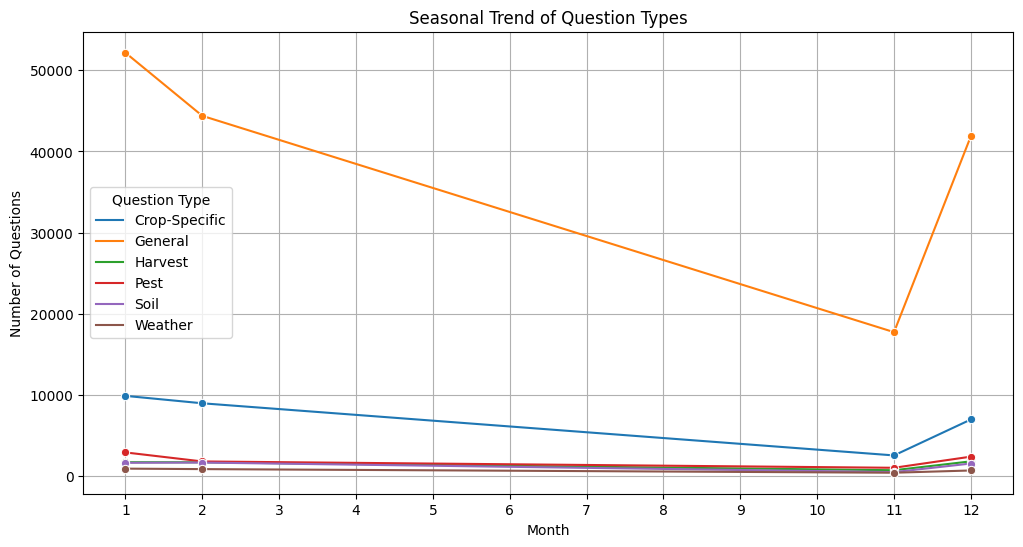

In [107]:
# Ensure month column exists
df['q_month_num'] = pd.DatetimeIndex(df['question_sent']).month

monthly_questions = (
    df.groupby(['q_month_num', 'question_type'])
    ['question_id']
    .count()
    .reset_index(name='count')
)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=monthly_questions,
    x='q_month_num',
    y='count',
    hue='question_type',
    marker='o'
)
plt.title("Seasonal Trend of Question Types")
plt.xlabel("Month")
plt.ylabel("Number of Questions")
plt.xticks(range(1,13))
plt.legend(title="Question Type")
plt.grid(True)
plt.savefig('Seasonal Trend of Question Types.png')
plt.show()


In [108]:
df['question_topic']

0              None
1            rabbit
2           poultry
3               pig
4           coconut
             ...   
11523988      plant
11523989    cabbage
11523990      maize
11523991       bird
11523992     tomato
Name: question_topic, Length: 11523993, dtype: object

In [109]:
# Select the column and drop nulls
questions = df['question_content'].dropna().astype(str)

# Simple cleaning function
def clean_text(text):
    text = text.lower()                       # lowercase
    text = re.sub(r'[^a-z\s]', '', text)     # remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text)         # remove extra spaces
    return text.strip()

questions_cleaned = questions.apply(clean_text)


In [110]:
from collections import Counter

# Split words and count
all_words = ' '.join(questions_cleaned).split()
word_counts = Counter(all_words)

# Show top 20 most common keywords
top_keywords = word_counts.most_common(20)
print(top_keywords)


[('q', 5244869), ('to', 3963923), ('i', 3876572), ('is', 3766055), ('the', 3621837), ('of', 3522370), ('what', 3007385), ('in', 2908717), ('can', 2732272), ('how', 2456453), ('a', 1862606), ('which', 1840163), ('and', 1688307), ('plant', 1686467), ('maize', 1481162), ('do', 1448881), ('my', 1445847), ('for', 1372981), ('are', 1065255), ('best', 1060991)]


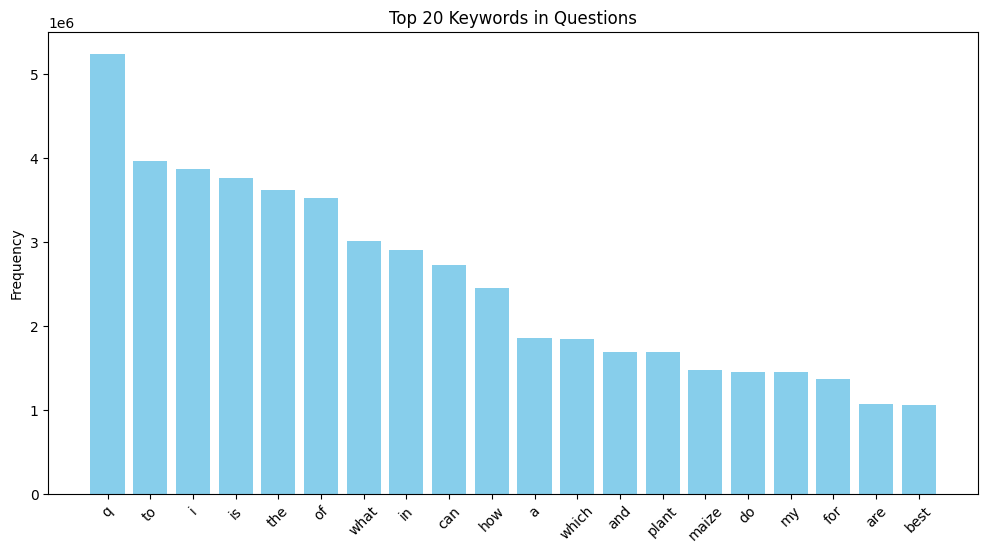

In [80]:
top_words, top_counts = zip(*top_keywords)

plt.figure(figsize=(12,6))
plt.bar(top_words, top_counts, color='skyblue')
plt.xticks(rotation=45)
plt.title("Top 20 Keywords in Questions")
plt.ylabel("Frequency")
plt.show()

In [ ]:

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Keyword Density Word Cloud")
plt.show()

In [ ]:
# Example: Pest-related questions
pest_questions = df[df['question_type']=='Pest']['question_content'].dropna()
pest_words = ' '.join(pest_questions).lower().split()
Counter(pest_words).most_common(10)

# Challenge 5: Beyond Farming - Financial Inclusion and Livelihood 

In [111]:
FINANCIAL_KEYWORDS = {
    'Market_Prices': [
        'price','market','sell','buy','rate','cost','demand','supply'
    ],
    'Credit_Loans': [
        'loan','credit','borrow','interest','repay','debt','finance','bank','sacco','microfinance'
    ],
    'Livelihood': [
        'income','profit','business','side income','employment','earning','livelihood','expenses'
    ]
}

In [112]:
def classify_financial_topic(text):
    text = str(text).lower()
    for topic, keywords in FINANCIAL_KEYWORDS.items():
        if any(k in text for k in keywords):
            return topic
    return 'Non_Financial'


In [113]:
df['financial_topic'] = df['question_content'].apply(classify_financial_topic)


In [114]:
financial_share = (
    df['financial_topic']
    .value_counts(normalize=True)
    .mul(100)
    .reset_index(name='percentage')
    .rename(columns={'index':'financial_topic'})
)


In [115]:
print(financial_share.columns)
# ['financial_topic', 'percentage']


Index(['financial_topic', 'percentage'], dtype='object')


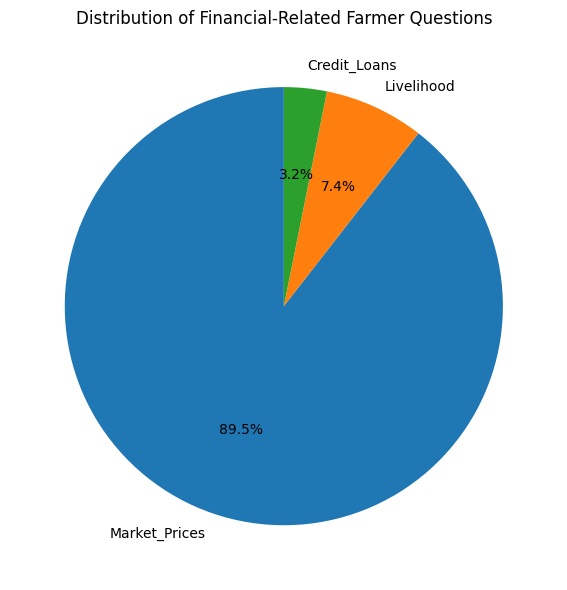

In [116]:
plt.figure(figsize=(6,6))

pie_data = financial_share[
    financial_share['financial_topic'] != 'Non_Financial'
]

plt.pie(
    pie_data['percentage'],
    labels=pie_data['financial_topic'],
    autopct='%1.1f%%',
    startangle=90
)

plt.title("Distribution of Financial-Related Farmer Questions")
plt.tight_layout()
plt.savefig('Distribution of Financial-Related Farmer Questions')
plt.show()

In [117]:
print(financial_share.head())
print(financial_share.columns)


  financial_topic  percentage
0   Non_Financial   92.495804
1   Market_Prices    6.714244
2      Livelihood    0.553098
3    Credit_Loans    0.236854
Index(['financial_topic', 'percentage'], dtype='object')


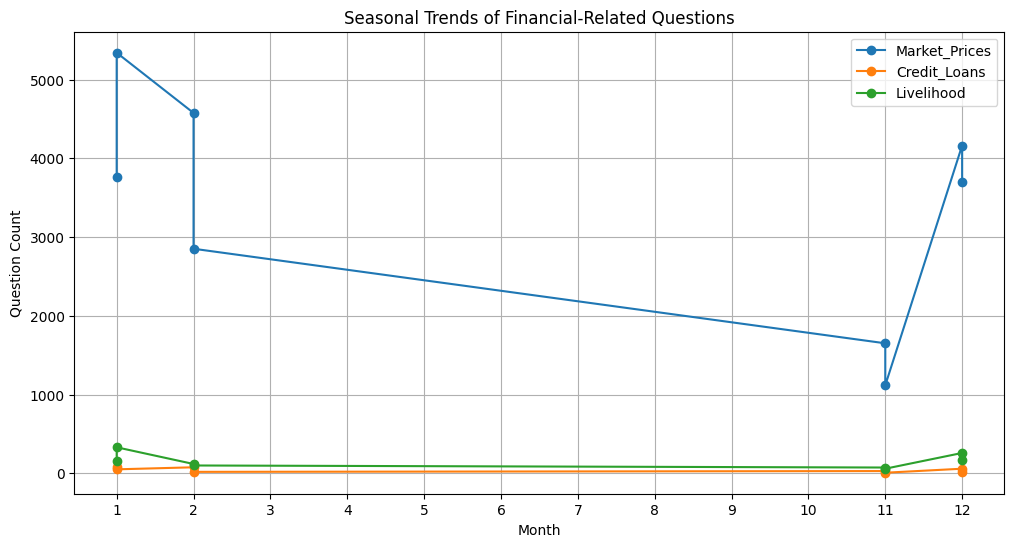

In [118]:
# Seasonal + Country Pattern (Financial Topics)
# 1) Do financial questions peak seasonally ?


df['q_month'] = pd.to_datetime(df['question_sent']).dt.month

seasonal_finance = (
    df[df['financial_topic']!='Non_Financial']
    .groupby(['q_month','question_user_country_code','financial_topic'])
    ['question_id']
    .count()
    .reset_index(name='count')
)

plt.figure(figsize=(12,6))

for topic in ['Market_Prices','Credit_Loans','Livelihood']:
    subset = seasonal_finance[seasonal_finance['financial_topic']==topic]
    plt.plot(subset['q_month'], subset['count'], marker='o', label=topic)

plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Question Count")
plt.title("Seasonal Trends of Financial-Related Questions")
plt.legend()
plt.grid(True)
plt.savefig("Seasonal Trends of Financial-Related Questions")
plt.show()


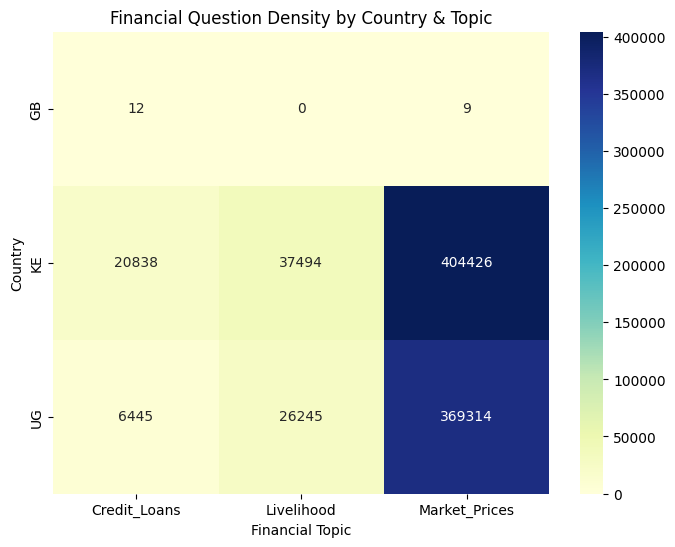

In [119]:
heatmap_data = (
    df[df['financial_topic']!='Non_Financial']
    .groupby(['question_user_country_code','financial_topic'])
    ['question_id']
    .count()
    .unstack(fill_value=0)
)

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Financial Question Density by Country & Topic")
plt.xlabel("Financial Topic")
plt.ylabel("Country")
plt.savefig("Financial Question Density by Country & Topic")
plt.show()

In [120]:
activity_corr = (
    df.groupby('financial_topic')
    .agg(
        avg_account_age=('account_age_days','mean'),
        total_questions=('question_id','count'),
        avg_questions_per_user=('question_id','mean')
    )
)

print(activity_corr)


                 avg_account_age  total_questions  avg_questions_per_user
financial_topic                                                          
Credit_Loans           76.135135            27295            3.341068e+07
Livelihood             93.400000            63739            2.755471e+07
Market_Prices         143.903303           773749            2.688988e+07
Non_Financial         136.300349         10659210            2.721120e+07


In [121]:
# Keep only financial-related questions
financial_df = df[df['financial_topic'] != 'Non_Financial']

# Ensure text is string
financial_text = financial_df['question_content'].dropna().astype(str)


In [122]:


# Flatten keyword list
financial_keywords_flat = [
    kw for keywords in FINANCIAL_KEYWORDS.values() for kw in keywords
]

def extract_financial_words(text):
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    return [w for w in words if w in financial_keywords_flat]

# Extract all financial words
financial_words = []
for text in financial_text:
    financial_words.extend(extract_financial_words(text))


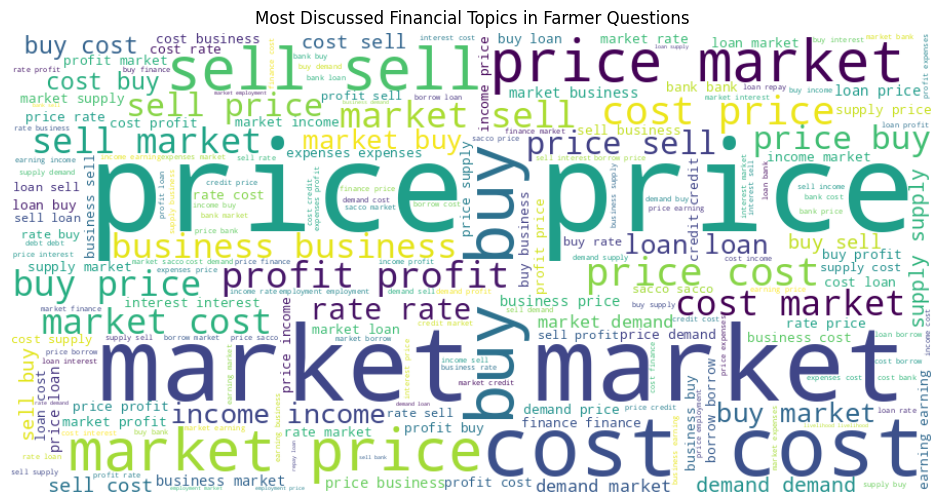

In [123]:
wordcloud = WordCloud(
    width=900,
    height=450,
    background_color='white',
    colormap='viridis'
).generate(' '.join(financial_words))

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Discussed Financial Topics in Farmer Questions")
plt.savefig("Most Discussed Financial Topics in Farmer Questions.")
plt.show()